In [ ]:
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

import os
import pandas as pd
import torch
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils.data import GeneFeatureDataset, seq_concat, select_cols
from utils.model import GeneInteractionModel
from utils.loss import BalancedMSELoss

import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from itertools import combinations

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

pd.options.mode.chained_assignment = None  # default='warn'

In [112]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# Create test/train splits for 5 models

In [3]:
finetune_data = pd.read_csv('../easy_prime/figure_rep/DeepPrime_ForFT_withGenes.csv')
finetune_data

,gene,ID,WT74_On,Edited74_On,PBSlen,RTlen,RT-PBSlen,Edit_pos,Edit_len,RHA_len,...,nGCcnt1,nGCcnt2,nGCcnt3,fGCcont1,fGCcont2,fGCcont3,MFE3,MFE4,DeepSpCas9_score,Measured_PE_efficiency
0,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTxxxxxxxxxxxxxxxxx...,13,8,21,5,1,3,...,8,4,12,61.538462,50.000000,57.142857,-1.7,-1.6,65.144363,6.410003
1,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGxxxxxxxxxxxxxxxx...,13,9,22,5,1,4,...,8,5,13,61.538462,55.555556,59.090909,-1.7,-1.6,65.144363,0.919506
2,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGAxxxxxxxxxxxxxxx...,13,10,23,5,1,5,...,8,5,13,61.538462,50.000000,56.521739,-1.7,-1.6,65.144363,5.100177
3,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACxxxxxxxxxxxxxx...,13,11,24,5,1,6,...,8,6,14,61.538462,54.545455,58.333333,-1.7,-1.6,65.144363,9.992335
4,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACGxxxxxxxxxxxxx...,13,12,25,5,1,7,...,8,7,15,61.538462,58.333333,60.000000,-1.7,-1.6,65.144363,3.479796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,15,11,26,1,1,10,...,5,5,10,33.333333,45.454545,38.461538,-1.1,0.0,52.229725,3.630080
195,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,15,11,26,1,1,10,...,5,5,10,33.333333,45.454545,38.461538,-1.1,0.0,52.229725,6.989605
196,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxTCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,16,11,27,1,1,10,...,5,5,10,31.250000,45.454545,37.037037,-1.6,0.0,52.229725,3.022388
197,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxGTCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,17,11,28,1,1,10,...,6,5,11,35.294118,45.454545,39.285714,-1.5,0.0,52.229725,2.146368


### At the end of this section, you have 5 different splits of test/train data. In each of the test sets, there is roughly equal representation across all the 8 genes. Additionally, if you concatenate all the test sets together across all 5 models, you will get all the 199 points. Additionally, each test/train pair contains all 199 points.

In [4]:
gene_indices = {'RNF2': [79, 155, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198], 'EMX1': [24, 50, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 177], 'VEGFA': [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], 'HEK3': [25, 49, 77, 92, 142, 144, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 'FANCF': [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 78, 91, 143], 'DNMT1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'HEK4': [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117], 'RUNX1': [118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]}

In [33]:
np.random.seed(42)

# Define the number of splits
num_splits = 5

# Initialize StratifiedKFold to ensure balanced splitting
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Combine all gene indices into a single list
all_gene_indices = np.concatenate(list(gene_indices.values()))


# Create labels for each gene based on their indices
gene_labels = np.zeros(len(all_gene_indices))        # Create a list with length 199
for i, gene_name in enumerate(gene_indices.keys()):  # For each gene
    gene_labels[gene_indices[gene_name]] = i         # Extract the indices respective to each gene. Every one of those positions should be converted to the index of that gene name in gene_indices dictionary.

# gene_labels is now a list where each of the 199 positions is annotated with the gene it refers to.
    
# List to store train/test splits
train_test_splits = []

# Iterate over the splits
for train_index, test_index in skf.split(all_gene_indices, gene_labels):
    # Initialize lists to store indices for train and test sets
    train_indices = []
    test_indices = []
    
    
    for gene_name, indices in gene_indices.items():  # Loops over each gene name and the indices (in this case, dictionary values, corresponding to each gene)
        # print(gene_name, indices)
        # Divide the indices into train and test sets
        gene_train_index = np.intersect1d(train_index, indices) # to find the intersection of the overall train and test indices (train_index and test_index) with the indices specific to the current gene (indices). This operation ensures that only the indices relevant to the current gene are retained for both the train and test sets.
        gene_test_index = np.intersect1d(test_index, indices)
        
        # Split each gene's data separately into train and test sets for each fold.
        train_indices.extend(gene_train_index)
        test_indices.extend(gene_test_index)
    
    # Shuffle the indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    num_validation_indices = int(0.2 * len(train_indices))                                                  # I want 10% of the indices to be used for validation
    validation_indices = list(np.random.choice(train_indices, size=num_validation_indices, replace=False))  # Randomly choose 10% of the indices for validation
    train_indices = [index for index in train_indices if index not in validation_indices]                   # Remove validation indices from train_indices
    

    # Append the train/test indices split to the list
    train_test_splits.append((train_indices, validation_indices, test_indices))
    print(len(train_indices), len(validation_indices), len(test_indices))

128 31 40
128 31 40
128 31 40
128 31 40
128 32 39


In [6]:
merged_list = []
for split in train_test_splits:
    
    genes_split = {}
    
    test = split[2]
    sub = finetune_data.loc[test] # Find the rows associated with the test data
    
    for i, row in sub.iterrows():
        gene = row['gene']
        
        if gene not in genes_split:
            genes_split[gene] = 0
            genes_split[gene] += 1
            
        else:
            genes_split[gene] += 1
    
    merged_list.append(genes_split)
        
print(merged_list)

[{'VEGFA': 5, 'HEK3': 6, 'RNF2': 5, 'FANCF': 5, 'HEK4': 4, 'EMX1': 5, 'DNMT1': 5, 'RUNX1': 5}, {'HEK4': 5, 'RNF2': 4, 'RUNX1': 5, 'EMX1': 5, 'FANCF': 6, 'DNMT1': 5, 'HEK3': 5, 'VEGFA': 5}, {'DNMT1': 5, 'EMX1': 5, 'VEGFA': 5, 'RNF2': 4, 'HEK3': 5, 'RUNX1': 5, 'HEK4': 5, 'FANCF': 6}, {'EMX1': 5, 'RUNX1': 5, 'HEK4': 5, 'HEK3': 5, 'VEGFA': 4, 'RNF2': 5, 'DNMT1': 5, 'FANCF': 6}, {'VEGFA': 5, 'DNMT1': 4, 'HEK4': 5, 'RUNX1': 4, 'RNF2': 5, 'HEK3': 6, 'FANCF': 5, 'EMX1': 5}]


In [89]:
merged_list_train = []
for split in train_test_splits:
    
    genes_split = {}
    
    train = split[0]
    sub = finetune_data.loc[train] # Find the rows associated with the test data
    
    for i, row in sub.iterrows():
        gene = row['gene']
        
        if gene not in genes_split:
            genes_split[gene] = 0
            genes_split[gene] += 1
            
        else:
            genes_split[gene] += 1
    
    merged_list_train.append(genes_split)
        
print(merged_list_train)

[{'FANCF': 23, 'RUNX1': 15, 'HEK4': 18, 'VEGFA': 18, 'EMX1': 18, 'HEK3': 19, 'DNMT1': 17, 'RNF2': 16}, {'VEGFA': 19, 'HEK3': 22, 'DNMT1': 17, 'RUNX1': 15, 'HEK4': 15, 'RNF2': 17, 'FANCF': 19, 'EMX1': 20}, {'VEGFA': 19, 'EMX1': 19, 'FANCF': 17, 'HEK3': 21, 'DNMT1': 17, 'RUNX1': 18, 'HEK4': 17, 'RNF2': 16}, {'HEK3': 22, 'HEK4': 16, 'VEGFA': 18, 'DNMT1': 17, 'RUNX1': 15, 'FANCF': 20, 'RNF2': 17, 'EMX1': 19}, {'VEGFA': 17, 'FANCF': 20, 'RNF2': 16, 'HEK4': 18, 'EMX1': 17, 'HEK3': 20, 'RUNX1': 19, 'DNMT1': 17}]


In [91]:
# Combine dictionaries into a DataFrame
df = pd.DataFrame(merged_list)

# Reorder columns to match alphabetical order of genes
df = df.reindex(sorted(df.columns), axis=1)
df.index = ['Split_0', 'Split_1', 'Split_2', 'Split_3', 'Split_4']

In [92]:
df

,DNMT1,EMX1,FANCF,HEK3,HEK4,RNF2,RUNX1,VEGFA
Split_0,5,5,5,6,4,5,5,5
Split_1,5,5,6,5,5,4,5,5
Split_2,5,5,6,5,5,4,5,5
Split_3,5,5,6,5,5,5,5,4
Split_4,4,5,5,6,5,5,4,5


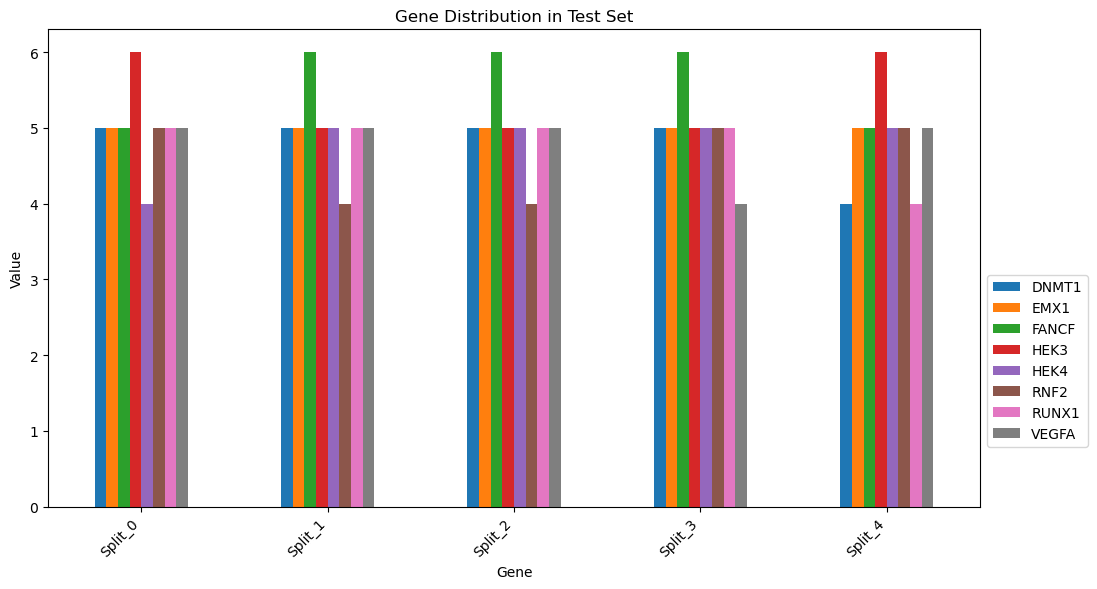

In [93]:
# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Gene')
plt.ylabel('Value')
plt.title('Gene Distribution in Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 0.5))

# Reduce distance between ticks on both axes
plt.locator_params(axis='x', tight=True, nbins=10)
plt.locator_params(axis='y', tight=True, nbins=10)

plt.show()

In [7]:
for split in train_test_splits:
     
    train = set(split[0])
    validation = set(split[1])
    test = set(split[2])
    
    all = train.union(validation, test)
    # all = train + validation + test
    # print(len(all))
    
    common_elements = train.intersection(validation, test)
    print(common_elements)
    
    for i in range(199):
        if i not in all:
            print(i)


set()
set()
set()
set()
set()


### Now, for each test/train index split up, I need to:

### - Take 10% of the test data for validation
### - Create x_train, g_train, and y_train
### - Create x_val, g_val, and y_val
### - Create x_test, g_test, and y_test

In [34]:
def get_wrapper(split, num_model):
    
    # Train and test
    train_indices = split[0]
    validation_indices = split[1]
    test_indices = split[2]
    
    #Prepare train
    x_train, g_train, y_train = get_training(finetune_data, train_indices, num_model)
    
    #Prepare validation
    x_validation, g_validation, y_validation = get_validation(finetune_data, validation_indices, num_model)
    
    #Prepare test
    x_test, g_test, y_test = get_testing(finetune_data, test_indices, num_model)
    
    return (x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test)
    

In [35]:
def get_training(dataset, train_indices, num_model):
    
    gene_path_train = 'data/genes/' + 'endogenous_train_trial2' + str(num_model) + '.npy'
    
    train_dataset = finetune_data.loc[train_indices]
    train_dataset = train_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error


    if not os.path.isfile(gene_path_train):
        g_train = seq_concat(train_dataset)
        np.save(gene_path_train, g_train)
    else:
        g_train = np.load(gene_path_train)


    train_features, train_target = select_cols(train_dataset)  #Trained target features 
    train_type = train_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_train = (train_features - mean) / std
    y_train = train_target
    y_train = pd.concat([y_train, train_type], axis=1)

    g_train = torch.tensor(g_train, dtype=torch.float32, device=device)
    x_train = torch.tensor(x_train.to_numpy(), dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_train, g_train, y_train])

In [36]:
def get_validation(dataset, validation_indices, num_model):
    
    gene_path_validation = 'data/genes/' + 'endogenous_val_trial2' + str(num_model) + '.npy'
    
    validation_dataset = finetune_data.loc[validation_indices]
    validation_dataset = validation_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error


    if not os.path.isfile(gene_path_validation):
        g_validation = seq_concat(validation_dataset)
        np.save(gene_path_validation, g_validation)
    else:
        g_validation = np.load(gene_path_validation)


    validation_features, validation_target = select_cols(validation_dataset)  
    validation_type = validation_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_validation = (validation_features - mean) / std
    y_validation = validation_target
    y_validation = pd.concat([y_validation, validation_type], axis=1)

    g_validation = torch.tensor(g_validation, dtype=torch.float32, device=device)
    x_validation = torch.tensor(x_validation.to_numpy(), dtype=torch.float32, device=device)
    y_validation = torch.tensor(y_validation.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_validation, g_validation, y_validation])

In [37]:
def get_testing(dataset, test_indices, num_model):
    

    gene_path_test = 'data/genes/' + 'endogenous_test_trial2' +  str(num_model) +'.npy'
    
    test_dataset = finetune_data.loc[test_indices]
    test_dataset = test_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error

    if not os.path.isfile(gene_path_test):
        g_test = seq_concat(test_dataset)
        np.save(gene_path_test, g_test)
    else:
        g_test = np.load(gene_path_test)

    test_features, test_target = select_cols(test_dataset)  #Test target features 
    test_type = test_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_test = (test_features - mean) / std
    y_test = test_target
    y_test = pd.concat([y_test, test_type], axis=1)

    g_test = torch.tensor(g_test, dtype=torch.float32, device=device)
    x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_test, g_test, y_test])

# Hyperparameter Optimization

In [14]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import optuna
import time
from optuna.trial import TrialState

In [82]:
class Optuna_Trainer:
    
    # Initializing attributes including training and testing sets g (one-hot encoding of input sequences), x (features), and y (Measured editing efficiencies).
    def __init__(self, model, x_train, g_train, y_train, x_y_validation, g_y_validation, y_validation): 
        self.g_train = g_train   # Training data for g
        self.x_train = x_train   # Training data for x 
        self.y_train = y_train   # Training data for y
        self.g_val = g_validation       # Validation data for g
        self.x_val = x_validation       # Validation data for x
        self.y_val = y_validation       # Validation data for y
        self.model = model       # Call machine learning model as an attribute of the object
        # self.lr = 1e-5           # Learning rate
        # self.wd = 1e-5           # Weight decay: Weight decay should typically be same value as the learning rate
        # self.bs = 8              # Batch size 
        # self.ep = 100            # Number of epochs
        
        # Patience represents the number of consecutive trials where the validation loss does not decrease (performance is not improved).
        
        self.delta = 1e-4        # Delta is the threshold needed for the difference between the previous minimum loss and the validation loss.

    # Set up hyperparameter search space
    def setup_trials(self, trial):
        
        #Parameters that need to be searched
        self.lr = trial.suggest_categorical("lr", [1e-4,1e-3,5e-4,8e-4, 2e-3, 5e-3])   # Categorical values for learning rate
        self.wd = trial.suggest_categorical("wd", [1e-4,1e-3,1e-5,5e-4,8e-4, 2e-3, 5e-3])                                                       # Assign weight decay to be the same as the learning rate
        self.bs = trial.suggest_categorical("batch_size", [4, 8, 16, 32])           # Categorical values for batch size
        self.ep = trial.suggest_categorical("num_epochs", [200, 500, 1000])   # Categorical values for number of epochs
       
        self.patience = self.ep / 10       # Changing patience value to 20. 
        

        # Fixed parameters
        self.hs = 128                    # Hidden size
        self.nl = 1                      # Number of GRU layers
        self.schedule = True             # Learning rate scheduler
        
        # Print trial hyperparameters
        for key, value in trial.params.items():
            print("{}: {}".format(key, value))
    
    # Trains the DeepPrime model based on the provided testing and training data
    def train_model(self, trial): 
        
        min_loss = None                   #  Stores the minimum loss, initialize with no value
        early_stopping_counter = 0        #  Track how many consecutive epochs have occurred without improvement in the validation loss, used to prevent overfitting.

        #Trial object is created when Optuna generates a study object, so it's not something to explicitly point to
        self.setup_trials(trial) # Sets up the trial with a set of hyperparameters derived from the setup_trials function


        # Prepare the training data to run through the model
        train_dataset = GeneFeatureDataset(self.g_train, self.x_train, self.y_train) 
        train_loader = DataLoader(train_dataset, batch_size=self.bs, shuffle=True, drop_last=True) 

        # Prepare the testing and validation datasets
        val_dataset = GeneFeatureDataset(self.g_val, self.x_val, self.y_val) 
        val_loader = DataLoader(val_dataset, batch_size=self.bs, shuffle=True) # Q: Shuffle?

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd)   # Sets up optimizer, I am also using AdamW
        optimizer.zero_grad()  # Zeroes out gradients, kind of a "hack" where optimization is actually better when gradients are not stored
        
        criterion = BalancedMSELoss() # Loss function used in DeepPrime

        # print("epoch\ttrain_corr\ttrain_loss\ttrue_auc\tpred_auc\tval_corr\tval_loss\telapsed_time")
        for epoch in range(self.ep): # self.ep is the number of epochs, so here we are iterating through the epochs
            
            # Train
            self.model.train()  # Sets model in training mode. Make sure to use self.model because model is now an attribute of the class itself.
            
            train_loss = []    # List that will keep track of the loss across the entire epoch
            train_count = 0    # Number of samples processed in epoch
    

            # Works through each batch of data set up by the train_loader
            for i, (g_batch, x_batch, y_batch) in enumerate(train_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda() # We are on GPU, so move tensors to GPU

                # Update values for all three tensors. Following permutations used in DeepPrime.
                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)


                optimizer.zero_grad()  #Zero out gradient for each batch

                output = self.model(g_batch, x_batch) # Send g and x through the model

                total_loss = criterion(output, y_batch) # Calculate the loss between the model output and the actual measured efficiencies

                total_loss.backward() # Computes gradients of the loss with repsect to the model parameters
                optimizer.step()  # Applies optimization to update parameters

                train_loss.append(x_batch.size(0) * total_loss.detach().cpu().numpy()) # Multiplies batch-loss by batch size to normalize for different sized batches during training
                train_count += x_batch.size(0)  # Updates number of samples processed in the epoch

            train_loss = sum(train_loss) / train_count  # train_loss now represents the average training loss across batches for the ENTIRE epoch


            # Validation
            self.model.eval()  # Set model in evaluation mode
            
            val_loss = []
            val_count = 0

            # Same as with training batches
            for i, (g_batch, x_batch, y_batch) in enumerate(val_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda()

                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)
                
                output = self.model(g_batch, x_batch)  #Run validation data through model

                loss = criterion(output, y_batch)
                
                
                val_loss.append(x_batch.size(0) * loss.detach().cpu().numpy())
                val_count += x_batch.size(0)

            val_loss = sum(val_loss) / val_count


            # Summary of training progress
            # print("{}\t{:.4f}\t{:.4f}".format(epoch, train_loss, val_loss))

            trial.report(val_loss, epoch) # Reports the result of the current epoch to Optuna, so Optuna can keep track of model performance throughout the trial.
            

            if min_loss is None:
                min_loss = val_loss  
            elif min_loss - val_loss > self.delta:                    # If the difference between the previous minimum loss and the current validation loss is greater than delta, update values
                min_loss = val_loss                                   # Set the new minimum loss to current validation loss
                early_stopping_counter = 0                            # Reset to 0, indicating no consecutive epochs with increasing validation loss.
            elif min_loss - val_loss < self.delta:                    # No improvement in validation loss
                early_stopping_counter += 1                           # Consecutive epoch for which there is no improvement on validation loss
                if early_stopping_counter >= self.patience:           # At this point, further training is unlikely to improve/lower validation loss, so break
                    break

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return val_loss # #Returns the loss across the epochs, as this is the value we want to minimize

    def exec_study(self):
        study = optuna.create_study()                      # Creates Optuna study object, maximizing correlation
        study.optimize(self.train_model, n_trials=200)      # Runs train_model function n_trials times
        return self.print_result(study)                    # Prints out hyperparameters used for combination that generated lowest validation loss.
    
    def print_result(self, study):
        pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
        complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

        print("Study statistics:")
        print("Number of finished trials:", len(study.trials))
        print("Number of pruned trials:", len(pruned_trials))
        print("Number of complete trials:", len(complete_trials))

        print("Best trial:")
        best_trial = study.best_trial

        print("Value: ", best_trial.value)

        best_params = {}
        print("Params:")
        for key, value in best_trial.params.items():
            print("{}: {}".format(key, value))
            best_params[key] = value
        for key, value in best_trial.user_attrs.items():
            print("{}: {}".format(key, value))
            best_params[key] = value

        return best_params

In [83]:
# Run Optuna_Trainer

n_models = 5

for m in range(n_models):
    print(f"Training Model {m}")
    
    #Get the necessary information
    split = train_test_splits[m]   #There are the same number of splits as there are models
    x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test = get_wrapper(split, m)
    
    
    # Set random seed
    random_seed = m
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    
    print(device)

    # Load pre-trained model
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)  # Model
    model.load_state_dict(torch.load('models/ontarget/final/model_{}.pt'.format(m)))  # Loads weights, biases from this pre-trained model

    # Create a Trainer instance for each model
    trainer = Optuna_Trainer(model, x_train, g_train, y_train, x_validation, g_validation, y_validation)

    # Execute hyperparameter study
    trainer.exec_study()

    print(f"Model {m} complete.")

[I 2024-03-05 11:51:09,920] A new study created in memory with name: no-name-4793bd6b-5433-475b-81d6-7327fd499397


Training Model 0
cuda:0
lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:51:35,628] Trial 0 finished with value: 0.22808539675128076 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 0 with value: 0.22808539675128076.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:51:36,480] Trial 1 finished with value: 0.20551201701164246 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 1 with value: 0.20551201701164246.


lr: 0.0005
wd: 0.002
batch_size: 8
num_epochs: 200


[I 2024-03-05 11:51:39,361] Trial 2 finished with value: 0.2596837878227234 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 8, 'num_epochs': 200}. Best is trial 1 with value: 0.20551201701164246.


lr: 0.0005
wd: 0.0008
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:51:53,648] Trial 3 finished with value: 0.20544789010478604 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:51:59,784] Trial 4 finished with value: 0.24703533370648662 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 11:52:01,085] Trial 5 finished with value: 0.2461233191913174 and parameters: {'lr': 0.0005, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.002
wd: 1e-05
batch_size: 4
num_epochs: 1000


[I 2024-03-05 11:52:52,472] Trial 6 finished with value: 0.2547945692654579 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:53:04,514] Trial 7 finished with value: 0.2861464153374395 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:53:20,762] Trial 8 finished with value: 0.2994478880878418 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 500


[I 2024-03-05 11:53:25,806] Trial 9 finished with value: 0.2591462024757939 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 11:53:31,604] Trial 10 finished with value: 0.25631028413772583 and parameters: {'lr': 0.0001, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:53:32,296] Trial 11 finished with value: 0.2571774125099182 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:53:33,041] Trial 12 finished with value: 0.28052371740341187 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 500


[I 2024-03-05 11:53:57,587] Trial 13 finished with value: 0.28210164077820316 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:53:58,306] Trial 14 finished with value: 0.27743178606033325 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.002
wd: 0.0008
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:54:17,225] Trial 15 finished with value: 0.32769258176126786 and parameters: {'lr': 0.002, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:54:18,054] Trial 16 finished with value: 0.29802030324935913 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.005
batch_size: 4
num_epochs: 500


[I 2024-03-05 11:54:43,551] Trial 17 finished with value: 0.3391423600335275 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:54:44,270] Trial 18 finished with value: 0.27704256772994995 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:55:04,447] Trial 19 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 11:55:07,094] Trial 20 finished with value: 0.2645294964313507 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:55:25,752] Trial 21 finished with value: 0.2731718199868356 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:55:44,285] Trial 22 finished with value: 0.259539851257878 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:56:17,612] Trial 23 finished with value: 0.265236843978205 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:56:50,970] Trial 24 finished with value: 0.2609926308355024 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 11:57:24,270] Trial 25 finished with value: 0.25893277602811016 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0001
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 11:57:31,737] Trial 26 pruned. 


lr: 0.001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:57:45,150] Trial 27 finished with value: 0.2419183095616679 and parameters: {'lr': 0.001, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:57:55,570] Trial 28 finished with value: 0.26538386940956116 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 11:58:01,866] Trial 29 finished with value: 0.2569620933744215 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:58:03,204] Trial 30 finished with value: 0.24779488146305084 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:58:09,464] Trial 31 finished with value: 0.24760008242822462 and parameters: {'lr': 0.001, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:58:18,657] Trial 32 finished with value: 0.25486171053301904 and parameters: {'lr': 0.001, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:58:27,882] Trial 33 finished with value: 0.2526517645005257 and parameters: {'lr': 0.001, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.0001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:58:37,102] Trial 34 finished with value: 0.2566230796998547 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:58:55,944] Trial 35 finished with value: 0.2617172819952811 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:59:05,788] Trial 36 finished with value: 0.2622308187907742 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.002
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:59:17,369] Trial 37 finished with value: 0.2569976405751321 and parameters: {'lr': 0.002, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 11:59:22,786] Trial 38 finished with value: 0.46545469712826515 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.002
batch_size: 8
num_epochs: 500


[I 2024-03-05 11:59:32,621] Trial 39 finished with value: 0.2612136573560776 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 11:59:43,202] Trial 40 finished with value: 0.2576682702187569 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 11:59:44,518] Trial 41 finished with value: 0.2631975811335348 and parameters: {'lr': 0.0005, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 11:59:46,094] Trial 42 finished with value: 0.2627061855408453 and parameters: {'lr': 0.0005, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0001
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 11:59:48,515] Trial 43 finished with value: 0.26252431831052225 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:59:49,279] Trial 44 finished with value: 0.2624514102935791 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-03-05 11:59:52,639] Trial 45 finished with value: 0.27726202434109104 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 11:59:53,981] Trial 46 pruned. 


lr: 0.005
wd: 0.001
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:00:20,033] Trial 47 finished with value: 0.3346414719858477 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.001
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:00:23,747] Trial 48 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:00:24,465] Trial 49 finished with value: 0.2647865116596222 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 0.0008
batch_size: 16
num_epochs: 500


[I 2024-03-05 12:00:35,454] Trial 50 finished with value: 0.24819541746570217 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:00:48,077] Trial 51 finished with value: 0.2500782378258244 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:01:01,827] Trial 52 finished with value: 0.2631916970975937 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0008
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:01:14,590] Trial 53 finished with value: 0.265863012882971 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0001
wd: 0.002
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:01:29,098] Trial 54 finished with value: 0.25285254635157123 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:33,018] Trial 55 finished with value: 0.24246685206890106 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:36,358] Trial 56 finished with value: 0.24880419671535492 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:43,106] Trial 57 finished with value: 0.24322669208049774 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:46,444] Trial 58 finished with value: 0.24749724566936493 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:49,801] Trial 59 finished with value: 0.24618327617645264 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:53,145] Trial 60 finished with value: 0.24717718362808228 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:56,509] Trial 61 finished with value: 0.24618880450725555 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:01:59,871] Trial 62 finished with value: 0.2477542608976364 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:02:03,302] Trial 63 finished with value: 0.24796320497989655 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:02:06,971] Trial 64 finished with value: 0.2357872575521469 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:02:10,615] Trial 65 finished with value: 0.2374286651611328 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:02:14,542] Trial 66 finished with value: 0.22651031613349915 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.20544789010478604.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:04:11,950] Trial 84 finished with value: 0.29932538059449965 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:04:15,632] Trial 85 finished with value: 0.24306367337703705 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:04:21,550] Trial 86 finished with value: 0.26625218987464905 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:04:26,460] Trial 87 finished with value: 0.2528173327445984 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:04:29,736] Trial 88 finished with value: 0.23401670157909393 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:04:34,486] Trial 89 finished with value: 0.24132177233695984 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:04:36,202] Trial 90 finished with value: 0.23603254556655884 and parameters: {'lr': 0.002, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:04:53,576] Trial 91 finished with value: 0.25707688735377404 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:05:34,422] Trial 92 finished with value: 0.3006437478526946 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0001
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:06:05,797] Trial 93 pruned. 


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:06:20,009] Trial 94 finished with value: 0.2430356740951538 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:06:29,763] Trial 95 finished with value: 0.26794087021581586 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 500}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:06:36,361] Trial 96 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:06:38,328] Trial 97 finished with value: 0.24984169006347656 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:07:00,415] Trial 98 finished with value: 0.3259684662184408 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.002
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:07:07,448] Trial 99 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:07:09,481] Trial 100 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:07:13,162] Trial 101 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:07:16,404] Trial 102 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:07:22,316] Trial 103 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:07:28,210] Trial 104 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:07:36,801] Trial 105 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:07:55,420] Trial 106 finished with value: 0.2825359067609233 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:07:56,114] Trial 107 finished with value: 0.2769206464290619 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:08:58,466] Trial 108 finished with value: 0.3215634097014704 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:09:02,379] Trial 109 finished with value: 0.26652005314826965 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 500}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:09:09,025] Trial 110 finished with value: 0.265730082988739 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:09:15,369] Trial 111 finished with value: 0.2749890387058258 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:09:22,016] Trial 112 finished with value: 0.24883976578712463 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:09:25,716] Trial 113 finished with value: 0.2831180989742279 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:09:29,632] Trial 114 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:09:39,061] Trial 115 finished with value: 0.27829089760780334 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:10:01,166] Trial 116 finished with value: 0.34206160302123717 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:04,912] Trial 117 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:10:06,255] Trial 118 pruned. 


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:14,769] Trial 119 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:10:30,452] Trial 120 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:34,490] Trial 121 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:38,189] Trial 122 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:42,935] Trial 123 finished with value: 0.2937167286872864 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:49,257] Trial 124 pruned. 


lr: 0.0005
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:10:56,303] Trial 125 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:10:59,486] Trial 126 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:11:03,386] Trial 127 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:11:10,820] Trial 128 finished with value: 0.3043573498725891 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:11:26,392] Trial 129 pruned. 


lr: 0.0005
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:11:44,725] Trial 130 finished with value: 0.27840456991426404 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:11:48,436] Trial 131 finished with value: 0.2621239721775055 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:11:51,694] Trial 132 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:12:02,058] Trial 133 finished with value: 0.23912584781646729 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:12:05,778] Trial 134 finished with value: 0.2563171684741974 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:12:09,457] Trial 135 finished with value: 0.2826646864414215 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:12:13,100] Trial 136 pruned. 


lr: 0.001
wd: 0.001
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:12:14,753] Trial 137 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:12:18,411] Trial 138 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:12:50,103] Trial 139 finished with value: 0.3083286775696662 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:12:57,328] Trial 140 pruned. 


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:12:58,440] Trial 141 pruned. 


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:12:59,542] Trial 142 pruned. 


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:13:00,653] Trial 143 pruned. 


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:13:01,764] Trial 144 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:13:02,875] Trial 145 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:13:03,944] Trial 146 pruned. 


lr: 0.0008
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:13:15,085] Trial 147 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:13:34,169] Trial 148 finished with value: 0.33280950207864085 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:13:38,441] Trial 149 finished with value: 0.2659263610839844 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 500}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:13:47,286] Trial 150 finished with value: 0.27461504840081735 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:13:53,897] Trial 151 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:14:01,724] Trial 152 finished with value: 0.28338339924812317 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:14:07,021] Trial 153 finished with value: 0.26189881563186646 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:14:14,818] Trial 154 pruned. 


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:14:18,157] Trial 155 pruned. 


lr: 0.005
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:14:25,953] Trial 156 finished with value: 0.28429657220840454 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:14:51,070] Trial 157 finished with value: 0.40233560050687484 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:14:54,011] Trial 158 pruned. 


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:14:59,202] Trial 159 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:15:19,542] Trial 160 finished with value: 0.33880414597449765 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:26,174] Trial 161 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:32,773] Trial 162 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:37,752] Trial 163 finished with value: 0.28129133582115173 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:45,078] Trial 164 finished with value: 0.2492571473121643 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:49,139] Trial 165 finished with value: 0.2490464746952057 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:52,504] Trial 166 finished with value: 0.25185254216194153 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:15:54,563] Trial 167 finished with value: 0.2420491725206375 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:15:59,873] Trial 168 finished with value: 0.24753794074058533 and parameters: {'lr': 0.002, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:03,621] Trial 169 finished with value: 0.24459035694599152 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.001
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:16:20,410] Trial 170 finished with value: 0.2609566608744283 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:23,860] Trial 171 finished with value: 0.2629314064979553 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:31,159] Trial 172 finished with value: 0.24317574501037598 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:34,709] Trial 173 finished with value: 0.2433655858039856 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:38,408] Trial 174 finished with value: 0.24890445172786713 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:16:39,521] Trial 175 finished with value: 0.26381170749664307 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:43,211] Trial 176 finished with value: 0.2626643478870392 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:46,920] Trial 177 finished with value: 0.2718249261379242 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:16:54,298] Trial 178 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:17:01,695] Trial 179 finished with value: 0.2662491500377655 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:17:08,617] Trial 180 finished with value: 0.2610333263874054 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 500}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:17:20,009] Trial 181 finished with value: 0.25082287192344666 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:17:23,436] Trial 182 finished with value: 0.2512965500354767 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:17:27,143] Trial 183 finished with value: 0.2609635293483734 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:17:30,841] Trial 184 finished with value: 0.2581205368041992 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:17:34,531] Trial 185 finished with value: 0.26239854097366333 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:17:46,130] Trial 186 finished with value: 0.30960758655301984 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.002
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:17:47,251] Trial 187 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:18:45,445] Trial 188 finished with value: 0.3333927931324128 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:18:48,724] Trial 189 pruned. 


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:18:54,259] Trial 190 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:03,625] Trial 191 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:07,285] Trial 192 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:13,883] Trial 193 pruned. 


lr: 0.005
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:19,747] Trial 194 finished with value: 0.2981826364994049 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:25,784] Trial 195 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:35,095] Trial 196 finished with value: 0.27760210633277893 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.20499539375305176.


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:19:38,426] Trial 197 pruned. 


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:19:48,350] Trial 198 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:19:50,429] Trial 199 pruned. 
[I 2024-03-05 12:19:50,504] A new study created in memory with name: no-name-9d5a5385-66e1-4c12-8e17-e7ea2c9433e9


Study statistics:
Number of finished trials: 200
Number of pruned trials: 55
Number of complete trials: 145
Best trial:
Value:  0.20499539375305176
Params:
lr: 0.005
wd: 0.0008
batch_size: 32
num_epochs: 1000
Model 0 complete.
Training Model 1
cuda:0
lr: 0.001
wd: 0.0005
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:20:06,220] Trial 0 finished with value: 0.21677642772274633 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 0 with value: 0.21677642772274633.


lr: 0.0008
wd: 0.0008
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:20:08,298] Trial 1 finished with value: 0.21325175512221553 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 200}. Best is trial 1 with value: 0.21325175512221553.


lr: 0.002
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:20:20,760] Trial 2 finished with value: 0.20998757260461007 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 2 with value: 0.20998757260461007.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:20:33,528] Trial 3 finished with value: 0.16340504154082267 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.001
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:20:41,868] Trial 4 finished with value: 0.1846496020593951 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.002
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:20:47,680] Trial 5 finished with value: 0.20369736850261688 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.001
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:21:22,331] Trial 6 finished with value: 0.23310106656243723 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.001
wd: 0.002
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:21:28,331] Trial 7 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:21:44,000] Trial 8 finished with value: 0.22111208496555204 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.005
wd: 0.002
batch_size: 16
num_epochs: 500


[I 2024-03-05 12:21:51,932] Trial 9 finished with value: 0.22726379094585294 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 500}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0005
wd: 0.001
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:22:15,982] Trial 10 finished with value: 0.21981102035891625 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 500}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.005
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:22:22,514] Trial 11 finished with value: 0.19824773313537722 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.005
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:22:34,627] Trial 12 finished with value: 0.1961001229863013 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0001
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:22:51,725] Trial 13 finished with value: 0.20209664298642066 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:22:59,737] Trial 14 finished with value: 0.17991870353298803 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:23:00,965] Trial 15 finished with value: 0.1872016042470932 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:23:24,210] Trial 16 finished with value: 0.2067919344671311 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:23:32,245] Trial 17 finished with value: 0.1997836794584028 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.005
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:23:36,916] Trial 18 finished with value: 0.19968263420366472 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:23:39,054] Trial 19 finished with value: 0.20569667220115662 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 500}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0005
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:23:55,607] Trial 20 finished with value: 0.1903323733037518 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.001
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:24:03,639] Trial 21 finished with value: 0.17326402135433688 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.005
wd: 0.001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:24:15,281] Trial 22 finished with value: 0.21455624747660854 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.001
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:24:23,381] Trial 23 finished with value: 0.19025426958837816 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.002
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:24:29,609] Trial 24 finished with value: 0.20668052713717183 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:24:37,611] Trial 25 finished with value: 0.19896510051142785 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.0001
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:24:54,052] Trial 26 finished with value: 0.21064989412984542 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 3 with value: 0.16340504154082267.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:24:58,269] Trial 27 finished with value: 0.15667852230610385 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 500


[I 2024-03-05 12:25:06,990] Trial 28 finished with value: 0.18961487758544185 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:25:15,056] Trial 29 finished with value: 0.18771724018358416 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:25:18,450] Trial 30 finished with value: 0.18800883812289085 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:25:22,793] Trial 31 finished with value: 0.21014821481320164 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:25:24,000] Trial 32 finished with value: 0.20648051798343658 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:25:28,466] Trial 33 finished with value: 0.22612176979741744 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.001
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:25:32,724] Trial 34 finished with value: 0.18346561395352887 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:25:44,193] Trial 35 finished with value: 0.17799535153373594 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:26:13,150] Trial 36 finished with value: 0.18295510257444075 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:26:29,557] Trial 37 finished with value: 0.22100334782754222 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:26:31,259] Trial 38 finished with value: 0.21893604820774448 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:26:36,618] Trial 39 finished with value: 0.19325006008148193 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:26:40,477] Trial 40 finished with value: 0.2059810786477981 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:26:51,808] Trial 41 finished with value: 0.18064106784520612 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.002
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:26:59,835] Trial 42 finished with value: 0.20671535691907328 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:27:07,910] Trial 43 finished with value: 0.2302675453885909 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0001
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:27:16,626] Trial 44 finished with value: 0.2543907751960139 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:27:29,530] Trial 45 finished with value: 0.2475945065098424 and parameters: {'lr': 0.002, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.005
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:28:01,680] Trial 46 finished with value: 0.19756165621501784 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:28:07,685] Trial 47 finished with value: 0.20329042355860433 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.002
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:28:19,112] Trial 48 pruned. 


lr: 0.0008
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:28:25,574] Trial 49 finished with value: 0.2776048529532648 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.001
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:28:29,995] Trial 50 finished with value: 0.22643366071485704 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:28:46,492] Trial 51 finished with value: 0.23243077147391536 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:28:54,529] Trial 52 finished with value: 0.23050461132680217 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:29:10,956] Trial 53 finished with value: 0.2175246448286118 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:29:18,957] Trial 54 finished with value: 0.2220739140625923 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:30:05,389] Trial 55 finished with value: 0.18326816010859706 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:30:06,063] Trial 56 finished with value: 0.22332750260829926 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:30:22,533] Trial 57 finished with value: 0.2044806614998848 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:30:28,618] Trial 58 finished with value: 0.1701888317062009 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:30:30,904] Trial 59 finished with value: 0.20552795596661105 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:31:13,104] Trial 60 finished with value: 0.21840876533139136 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:31:20,653] Trial 61 finished with value: 0.2279918054419179 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:31:26,657] Trial 62 finished with value: 0.22405187737557195 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:31:32,744] Trial 63 finished with value: 0.17260894660026796 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:31:45,654] Trial 64 finished with value: 0.25313522738795124 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:31:53,664] Trial 65 finished with value: 0.22041274030362407 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 16
num_epochs: 500


[I 2024-03-05 12:32:01,429] Trial 66 finished with value: 0.2153124568923827 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:32:18,058] Trial 67 finished with value: 0.20925826507229958 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:32:18,807] Trial 68 finished with value: 0.20291613042354584 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:32:27,492] Trial 69 finished with value: 0.22399476074403332 and parameters: {'lr': 0.0005, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:32:35,518] Trial 70 finished with value: 0.1948604578933408 and parameters: {'lr': 0.002, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:32:43,614] Trial 71 finished with value: 0.1970442235469818 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.002
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:32:51,630] Trial 72 finished with value: 0.19329355801305464 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:32:59,648] Trial 73 finished with value: 0.19593855546366784 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:33:07,683] Trial 74 finished with value: 0.2049636199109016 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0001
wd: 1e-05
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:33:12,203] Trial 75 finished with value: 0.20595459399684782 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:33:14,337] Trial 76 finished with value: 0.18277187212820975 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:33:22,358] Trial 77 finished with value: 0.2038167515589345 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.005
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:34:30,872] Trial 78 finished with value: 0.2007962390780449 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:34:53,904] Trial 79 finished with value: 0.20597466153483238 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:34:56,189] Trial 80 finished with value: 0.19335808580921543 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:34:58,455] Trial 81 finished with value: 0.19210681030827184 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:35:00,730] Trial 82 finished with value: 0.2045980014147297 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:35:03,003] Trial 83 finished with value: 0.2132622532306179 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:35:05,294] Trial 84 finished with value: 0.19991305326261827 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:35:09,337] Trial 85 finished with value: 0.21607214837305008 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:35:10,577] Trial 86 pruned. 


lr: 0.001
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:35:27,877] Trial 87 finished with value: 0.2205034955855339 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.002
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:35:32,539] Trial 88 finished with value: 0.21334478018745298 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:35:49,803] Trial 89 finished with value: 0.21405688408882387 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:36:25,830] Trial 90 finished with value: 0.22575761906562314 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:36:44,228] Trial 91 finished with value: 0.22138437676814296 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:37:14,207] Trial 92 finished with value: 0.20818267233910098 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:37:23,211] Trial 93 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:37:27,910] Trial 94 finished with value: 0.23936447260841245 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0001
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:38:04,808] Trial 95 finished with value: 0.2241492901117571 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:38:13,336] Trial 96 finished with value: 0.22303368535733992 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:38:37,694] Trial 97 finished with value: 0.21242778339693624 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:38:56,068] Trial 98 finished with value: 0.21708594791350827 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:39:02,850] Trial 99 finished with value: 0.27173373776097454 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:39:05,259] Trial 100 finished with value: 0.20455578161824134 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:39:29,591] Trial 101 finished with value: 0.1649572755540571 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:39:44,986] Trial 102 finished with value: 0.31465500941680324 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:40:06,013] Trial 103 finished with value: 0.2227181883588914 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:40:24,045] Trial 104 finished with value: 0.2077522700832736 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:40:44,349] Trial 105 finished with value: 0.32601132556315393 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:40:52,373] Trial 106 finished with value: 0.2328839720256867 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:40:53,532] Trial 107 finished with value: 0.2119114100933075 and parameters: {'lr': 0.002, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:40:59,505] Trial 108 finished with value: 0.2531695096723495 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.005
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:41:22,478] Trial 109 finished with value: 0.23787237583629547 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:41:38,907] Trial 110 finished with value: 0.2222793871356595 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:41:59,317] Trial 111 finished with value: 0.3367062960901568 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:42:14,010] Trial 112 finished with value: 0.3679878158915427 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:42:45,892] Trial 113 finished with value: 0.2107525509932349 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:42:58,482] Trial 114 finished with value: 0.204375869804813 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:43:00,593] Trial 115 finished with value: 0.1880180436757303 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.002
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:43:23,722] Trial 116 finished with value: 0.21052523630280648 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:43:31,748] Trial 117 finished with value: 0.25973416288052836 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0001
wd: 0.001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:43:48,264] Trial 118 finished with value: 0.24413488949498824 and parameters: {'lr': 0.0001, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:44:23,496] Trial 119 finished with value: 0.2205823626249067 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:44:27,010] Trial 120 finished with value: 0.2161765593674875 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.001
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:44:29,297] Trial 121 finished with value: 0.2245920185119875 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.001
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:44:31,421] Trial 122 finished with value: 0.22480520702177478 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:44:33,526] Trial 123 finished with value: 0.21675017572218372 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.001
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:44:35,699] Trial 124 finished with value: 0.2044387387652551 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:44:43,799] Trial 125 finished with value: 0.26125170771152745 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0005
wd: 0.001
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:45:00,433] Trial 126 finished with value: 0.24383010595075547 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:45:02,769] Trial 127 finished with value: 0.21306414758005449 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:45:04,810] Trial 128 finished with value: 0.2047693282365799 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 1e-05
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:46:14,547] Trial 129 finished with value: 0.19252078235149384 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:46:22,726] Trial 130 finished with value: 0.24535099152595766 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:46:30,847] Trial 131 finished with value: 0.2106637526904383 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:46:38,976] Trial 132 finished with value: 0.20450021855292783 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.005
batch_size: 4
num_epochs: 200


[I 2024-03-05 12:46:53,005] Trial 133 finished with value: 0.22115512961341488 and parameters: {'lr': 0.001, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:46:56,378] Trial 134 finished with value: 0.23055971918567533 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.001
wd: 0.0008
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:47:19,815] Trial 135 finished with value: 0.20960620814754116 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 500}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:22,150] Trial 136 finished with value: 0.18189572951486033 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:24,489] Trial 137 finished with value: 0.18197016129570623 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:26,872] Trial 138 finished with value: 0.17916530947531423 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:29,204] Trial 139 finished with value: 0.1807578057050705 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:31,530] Trial 140 finished with value: 0.17829970198292885 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:33,871] Trial 141 finished with value: 0.17951882702689018 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:36,207] Trial 142 finished with value: 0.17945442853435392 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:38,530] Trial 143 finished with value: 0.17741740807410208 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:40,860] Trial 144 finished with value: 0.17683452463919117 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:43,206] Trial 145 finished with value: 0.1772146580680724 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:45,541] Trial 146 finished with value: 0.17672558945994224 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:47,871] Trial 147 finished with value: 0.17718641508010127 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:50,200] Trial 148 finished with value: 0.18189477343713084 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:52,543] Trial 149 finished with value: 0.17995415051137248 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:54,872] Trial 150 finished with value: 0.18117162921736318 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:57,199] Trial 151 finished with value: 0.18282711505889893 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:47:59,565] Trial 152 finished with value: 0.18167851000062882 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:01,917] Trial 153 finished with value: 0.17972119489023763 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:04,260] Trial 154 finished with value: 0.18484403337201766 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:06,587] Trial 155 finished with value: 0.18125162538020842 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:08,916] Trial 156 finished with value: 0.1817838261204381 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:11,328] Trial 157 finished with value: 0.18467383327022677 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:14,378] Trial 158 finished with value: 0.18373901421023953 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:17,839] Trial 159 finished with value: 0.180535473169819 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:20,153] Trial 160 finished with value: 0.17626200952837545 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:23,194] Trial 161 finished with value: 0.17729051891834505 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:26,234] Trial 162 finished with value: 0.17833701641328872 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:28,554] Trial 163 finished with value: 0.17925261730147946 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:32,136] Trial 164 finished with value: 0.18556692282999715 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:35,982] Trial 165 finished with value: 0.19897547171961877 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:38,312] Trial 166 finished with value: 0.1780306706505437 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:40,633] Trial 167 finished with value: 0.18172061875943216 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:43,679] Trial 168 finished with value: 0.181424512978523 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:46,008] Trial 169 finished with value: 0.18279211607671553 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:49,041] Trial 170 finished with value: 0.18495020558757166 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:52,075] Trial 171 finished with value: 0.18473536352957448 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:54,414] Trial 172 finished with value: 0.18493714399876132 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:56,738] Trial 173 finished with value: 0.18990768155743998 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:48:59,775] Trial 174 finished with value: 0.18471639963888353 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:02,819] Trial 175 finished with value: 0.18293059737451614 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:05,180] Trial 176 finished with value: 0.18520817881630314 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:07,539] Trial 177 finished with value: 0.1878612498121877 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0001
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:09,859] Trial 178 finished with value: 0.1897867360422688 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:12,907] Trial 179 finished with value: 0.17868846654891968 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.002
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:16,347] Trial 180 finished with value: 0.1903689407533215 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:19,799] Trial 181 finished with value: 0.19484751359108957 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:23,262] Trial 182 finished with value: 0.1891927747957168 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:26,714] Trial 183 finished with value: 0.1939096022998133 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:30,150] Trial 184 finished with value: 0.18919734320332926 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:33,612] Trial 185 finished with value: 0.18972379786352958 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:49:34,842] Trial 186 finished with value: 0.1976938545703888 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:38,328] Trial 187 finished with value: 0.19182346617021867 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:41,786] Trial 188 finished with value: 0.1936004392562374 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.002
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:45,247] Trial 189 finished with value: 0.1993870860145938 and parameters: {'lr': 0.002, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:49,052] Trial 190 finished with value: 0.19792679673241032 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:52,082] Trial 191 finished with value: 0.182266267557298 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:55,891] Trial 192 finished with value: 0.1890184590893407 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:49:58,215] Trial 193 finished with value: 0.1904535183022099 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:50:01,253] Trial 194 finished with value: 0.18059639921111445 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:50:04,710] Trial 195 finished with value: 0.19352395880606868 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:50:07,745] Trial 196 finished with value: 0.1837523877620697 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:50:11,323] Trial 197 finished with value: 0.1892901312920355 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0008
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:50:14,781] Trial 198 finished with value: 0.18999272632983424 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:50:18,226] Trial 199 finished with value: 0.194137440093102 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 27 with value: 0.15667852230610385.
[I 2024-03-05 12:50:18,309] A new study created in memory with name: no-name-f6b9e30d-ac7d-4241-b113-976b938dd355


Study statistics:
Number of finished trials: 200
Number of pruned trials: 4
Number of complete trials: 196
Best trial:
Value:  0.15667852230610385
Params:
lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 200
Model 1 complete.
Training Model 2
cuda:0
lr: 0.0005
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:50:36,458] Trial 0 finished with value: 0.22377121592721633 and parameters: {'lr': 0.0005, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.001
wd: 0.0005
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:51:02,619] Trial 1 finished with value: 0.2586016832820831 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 500}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:51:04,290] Trial 2 finished with value: 0.22816550731658936 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.002
wd: 0.001
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:51:27,996] Trial 3 finished with value: 0.33001452203719844 and parameters: {'lr': 0.002, 'wd': 0.001, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.001
wd: 0.0001
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:51:45,936] Trial 4 finished with value: 0.23489693960835856 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.002
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:51:47,670] Trial 5 finished with value: 0.22762221386355738 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.005
wd: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:52:00,861] Trial 6 finished with value: 0.23103264334701723 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:52:02,646] Trial 7 finished with value: 0.23536217212677002 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 0 with value: 0.22377121592721633.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:52:04,324] Trial 8 finished with value: 0.21674998104572296 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0001
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:52:19,054] Trial 9 finished with value: 0.22815029851851926 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:52:19,768] Trial 10 finished with value: 0.2265528440475464 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 1e-05
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:52:28,457] Trial 11 finished with value: 0.22550503380836978 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.0005
batch_size: 16
num_epochs: 500


[I 2024-03-05 12:52:31,550] Trial 12 finished with value: 0.22258011516063445 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 12:52:32,859] Trial 13 finished with value: 0.22972399861581863 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.0005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:52:38,928] Trial 14 finished with value: 0.2209744837976271 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:52:45,556] Trial 15 finished with value: 0.21845968067646027 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:52:51,672] Trial 16 finished with value: 0.21824659407138824 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:52:57,787] Trial 17 finished with value: 0.21826179325580597 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:01,134] Trial 18 finished with value: 0.21815812587738037 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:04,483] Trial 19 finished with value: 0.21808329224586487 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:53:05,381] Trial 20 finished with value: 0.2196718454360962 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:08,723] Trial 21 finished with value: 0.2186858206987381 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:12,066] Trial 22 finished with value: 0.21837805211544037 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:15,423] Trial 23 finished with value: 0.2193126231431961 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:18,763] Trial 24 finished with value: 0.21740283071994781 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:22,102] Trial 25 finished with value: 0.21842147409915924 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:25,466] Trial 26 finished with value: 0.21781791746616364 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:53:28,887] Trial 27 finished with value: 0.22039136290550232 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.005
wd: 0.0008
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:53:44,159] Trial 28 finished with value: 0.27904069375607277 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.002
wd: 0.0008
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:53:50,716] Trial 29 finished with value: 0.2552113049933987 and parameters: {'lr': 0.002, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:53:56,644] Trial 30 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:54:00,824] Trial 31 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:54:03,981] Trial 32 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:54:07,137] Trial 33 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:55:11,097] Trial 34 finished with value: 0.2697198756279484 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:55:13,661] Trial 35 finished with value: 0.23774349689483643 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:55:17,803] Trial 36 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 12:55:44,235] Trial 37 finished with value: 0.22411177379469718 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:55:45,852] Trial 38 finished with value: 0.22880399227142334 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.005
wd: 0.0005
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:56:10,273] Trial 39 finished with value: 0.2670294805880516 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-03-05 12:56:15,392] Trial 40 finished with value: 0.2269755890292506 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:56:22,821] Trial 41 finished with value: 0.22242267429828644 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:56:30,307] Trial 42 finished with value: 0.2240111231803894 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:56:37,744] Trial 43 finished with value: 0.22167232632637024 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:56:42,225] Trial 44 finished with value: 0.22561414539813995 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:56:42,927] Trial 45 finished with value: 0.22683833539485931 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.002
wd: 0.001
batch_size: 8
num_epochs: 500


[I 2024-03-05 12:57:02,756] Trial 46 finished with value: 0.25436948287871575 and parameters: {'lr': 0.002, 'wd': 0.001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:57:10,344] Trial 47 finished with value: 0.22245502471923828 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.0001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:57:21,008] Trial 48 finished with value: 0.22351219192627939 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 12:57:21,889] Trial 49 finished with value: 0.22179658710956573 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:57:27,916] Trial 50 finished with value: 0.2254384458065033 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:57:35,588] Trial 51 finished with value: 0.22419621050357819 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:57:43,272] Trial 52 finished with value: 0.22350184619426727 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:57:51,035] Trial 53 finished with value: 0.22296665608882904 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:57:54,250] Trial 54 pruned. 


lr: 0.0001
wd: 0.001
batch_size: 4
num_epochs: 1000


[I 2024-03-05 12:58:20,392] Trial 55 pruned. 


lr: 0.0008
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:58:24,794] Trial 56 finished with value: 0.22925160825252533 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.0008
batch_size: 16
num_epochs: 1000


[I 2024-03-05 12:58:35,377] Trial 57 finished with value: 0.22361767292022705 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 12:58:37,048] Trial 58 finished with value: 0.22714562714099884 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.001
batch_size: 8
num_epochs: 200


[I 2024-03-05 12:58:41,057] Trial 59 finished with value: 0.23452584709851973 and parameters: {'lr': 0.0008, 'wd': 0.001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:58:44,236] Trial 60 finished with value: 0.21777969598770142 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:58:47,454] Trial 61 finished with value: 0.218508780002594 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:58:50,665] Trial 62 finished with value: 0.22010435163974762 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:58:53,880] Trial 63 finished with value: 0.2192866951227188 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:01,478] Trial 64 finished with value: 0.21874868869781494 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:04,655] Trial 65 finished with value: 0.22078992426395416 and parameters: {'lr': 0.0001, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:07,861] Trial 66 finished with value: 0.21781416237354279 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:11,471] Trial 67 finished with value: 0.2206874042749405 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 8 with value: 0.21674998104572296.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 500


[I 2024-03-05 12:59:22,914] Trial 68 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:30,480] Trial 69 finished with value: 0.21408453583717346 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 69 with value: 0.21408453583717346.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:37,999] Trial 70 finished with value: 0.2134469598531723 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 70 with value: 0.2134469598531723.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:45,511] Trial 71 finished with value: 0.2145172506570816 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 70 with value: 0.2134469598531723.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 12:59:53,049] Trial 72 finished with value: 0.21276064217090607 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.21276064217090607.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:00,088] Trial 73 finished with value: 0.21837249398231506 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.21276064217090607.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:03,745] Trial 74 finished with value: 0.2161056101322174 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 72 with value: 0.21276064217090607.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:11,285] Trial 75 finished with value: 0.2099260687828064 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 75 with value: 0.2099260687828064.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:18,818] Trial 76 finished with value: 0.2079935222864151 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 76 with value: 0.2079935222864151.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:22,384] Trial 77 finished with value: 0.21430107951164246 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 76 with value: 0.2079935222864151.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:25,730] Trial 78 finished with value: 0.21376436948776245 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 76 with value: 0.2079935222864151.


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:00:36,222] Trial 79 finished with value: 0.21951126956170605 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 76 with value: 0.2079935222864151.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:43,651] Trial 80 finished with value: 0.20617499947547913 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:47,216] Trial 81 finished with value: 0.21324649453163147 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:50,792] Trial 82 finished with value: 0.21525751054286957 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:54,141] Trial 83 finished with value: 0.21490198373794556 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:00:57,497] Trial 84 finished with value: 0.21447131037712097 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:01:31,601] Trial 85 finished with value: 0.21334984081406747 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:01:51,800] Trial 86 finished with value: 0.21399881979150157 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.002
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:02:06,733] Trial 87 finished with value: 0.22510676662768087 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:02:18,419] Trial 88 finished with value: 0.22939282751852466 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.005
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:02:40,557] Trial 89 finished with value: 0.23102324431942356 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:02:43,027] Trial 90 finished with value: 0.2335521170208531 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:03:07,214] Trial 91 finished with value: 0.2277045528734884 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:03:23,863] Trial 92 finished with value: 0.2426786797661935 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:03:41,520] Trial 93 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:03:57,105] Trial 94 finished with value: 0.24313643670851184 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:04:17,158] Trial 95 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:04:47,886] Trial 96 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:04:57,375] Trial 97 finished with value: 0.22190701961517334 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:05:00,570] Trial 98 finished with value: 0.21276290714740753 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:05:29,215] Trial 99 finished with value: 0.2424934535257278 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:05:37,406] Trial 100 finished with value: 0.21412657345494918 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:05:40,515] Trial 101 finished with value: 0.2123752385377884 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:05:43,626] Trial 102 finished with value: 0.2107660323381424 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:05:46,735] Trial 103 finished with value: 0.21197140216827393 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:05:49,844] Trial 104 finished with value: 0.21363408863544464 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.002
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:05:55,813] Trial 105 finished with value: 0.22730226814746857 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:05:57,464] Trial 106 finished with value: 0.2181517630815506 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:00,551] Trial 107 finished with value: 0.21415285766124725 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:03,766] Trial 108 finished with value: 0.21156026422977448 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:07,857] Trial 109 finished with value: 0.2180580198764801 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:11,939] Trial 110 finished with value: 0.2205653339624405 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:16,127] Trial 111 finished with value: 0.22090572118759155 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:20,215] Trial 112 finished with value: 0.2212887555360794 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:24,300] Trial 113 finished with value: 0.22036394476890564 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:28,390] Trial 114 finished with value: 0.2191125750541687 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:32,474] Trial 115 finished with value: 0.2204670011997223 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:39,914] Trial 116 finished with value: 0.20996907353401184 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:47,275] Trial 117 finished with value: 0.2097192108631134 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:54,637] Trial 118 finished with value: 0.20993216335773468 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:06:58,719] Trial 119 finished with value: 0.21714456379413605 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:02,025] Trial 120 finished with value: 0.21298368275165558 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:09,447] Trial 121 finished with value: 0.21051931381225586 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:16,788] Trial 122 finished with value: 0.20718936622142792 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:20,859] Trial 123 finished with value: 0.21882422268390656 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:24,937] Trial 124 finished with value: 0.21847136318683624 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:29,021] Trial 125 finished with value: 0.21743136644363403 and parameters: {'lr': 0.0008, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:36,309] Trial 126 finished with value: 0.2112525999546051 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:07:38,053] Trial 127 finished with value: 0.21760466694831848 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.005
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:44,035] Trial 128 finished with value: 0.2483573704957962 and parameters: {'lr': 0.005, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:07:54,378] Trial 129 finished with value: 0.22076144814491272 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 80 with value: 0.20617499947547913.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:08:01,678] Trial 130 finished with value: 0.20362545549869537 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 130 with value: 0.20362545549869537.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:08:08,954] Trial 131 finished with value: 0.20027904212474823 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:08:16,523] Trial 132 finished with value: 0.2141968458890915 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:08:22,702] Trial 133 finished with value: 0.20996299386024475 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:08:29,925] Trial 134 finished with value: 0.20531047880649567 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:09:08,066] Trial 135 finished with value: 0.2739302847654589 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:09:11,134] Trial 136 finished with value: 0.2125580608844757 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:09:15,029] Trial 137 finished with value: 0.21691539883613586 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:09:17,527] Trial 138 finished with value: 0.22994032502174377 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:09:21,048] Trial 139 finished with value: 0.22423262894153595 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:09:40,238] Trial 140 finished with value: 0.22372568855362554 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:09:43,735] Trial 141 finished with value: 0.22348745167255402 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:09:51,015] Trial 142 finished with value: 0.21556250751018524 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:09:58,364] Trial 143 finished with value: 0.20990146696567535 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:05,657] Trial 144 finished with value: 0.2083379328250885 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:12,969] Trial 145 finished with value: 0.20349058508872986 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:16,482] Trial 146 finished with value: 0.21568264067173004 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:20,650] Trial 147 finished with value: 0.21650125086307526 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 131 with value: 0.20027904212474823.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:28,004] Trial 148 finished with value: 0.19735077023506165 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:35,304] Trial 149 finished with value: 0.20588557422161102 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:42,603] Trial 150 finished with value: 0.1986783742904663 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:49,886] Trial 151 finished with value: 0.19847789406776428 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:10:57,198] Trial 152 finished with value: 0.2008286714553833 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:11:01,350] Trial 153 finished with value: 0.2102019041776657 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:11:07,567] Trial 154 finished with value: 0.1984492689371109 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:11:14,846] Trial 155 finished with value: 0.20343826711177826 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:11:16,503] Trial 156 finished with value: 0.21589916944503784 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:11:23,776] Trial 157 finished with value: 0.19837456941604614 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:11:31,089] Trial 158 finished with value: 0.2014024257659912 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:11:34,612] Trial 159 finished with value: 0.21096758544445038 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:12:16,510] Trial 160 finished with value: 0.22019134365743206 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:12:19,701] Trial 161 finished with value: 0.2040698230266571 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:12:26,995] Trial 162 finished with value: 0.20892120897769928 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:12:34,324] Trial 163 finished with value: 0.19933436810970306 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 148 with value: 0.19735077023506165.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:12:41,698] Trial 164 finished with value: 0.19505362212657928 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:12:45,363] Trial 165 finished with value: 0.2072472721338272 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:12:51,148] Trial 166 finished with value: 0.21131747961044312 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:12:58,480] Trial 167 finished with value: 0.20172171294689178 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:05,792] Trial 168 finished with value: 0.20526473224163055 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:13:11,953] Trial 169 finished with value: 0.21249919504888595 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:19,245] Trial 170 finished with value: 0.19978797435760498 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:26,552] Trial 171 finished with value: 0.20281767845153809 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:33,852] Trial 172 finished with value: 0.19937199354171753 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:41,174] Trial 173 finished with value: 0.20322848856449127 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:48,534] Trial 174 finished with value: 0.20551440119743347 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:13:55,832] Trial 175 finished with value: 0.20907099545001984 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:03,143] Trial 176 finished with value: 0.20110152661800385 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:11,259] Trial 177 finished with value: 0.20292796194553375 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:18,628] Trial 178 finished with value: 0.19687198102474213 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:26,047] Trial 179 finished with value: 0.19971773028373718 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:33,350] Trial 180 finished with value: 0.204874187707901 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:40,680] Trial 181 finished with value: 0.20449329912662506 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:48,029] Trial 182 finished with value: 0.20128747820854187 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:14:55,381] Trial 183 finished with value: 0.20266233384609222 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:02,766] Trial 184 finished with value: 0.20697471499443054 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:10,953] Trial 185 finished with value: 0.212350532412529 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:16,986] Trial 186 finished with value: 0.21761828660964966 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:23,092] Trial 187 finished with value: 0.21600905060768127 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:29,118] Trial 188 finished with value: 0.215209499001503 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:15:30,208] Trial 189 finished with value: 0.20159025490283966 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:15:30,872] Trial 190 finished with value: 0.2091953605413437 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:15:32,547] Trial 191 finished with value: 0.21513590216636658 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:15:34,216] Trial 192 finished with value: 0.21343722939491272 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:15:35,883] Trial 193 finished with value: 0.21665914356708527 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:15:37,589] Trial 194 finished with value: 0.2163872867822647 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:45,009] Trial 195 finished with value: 0.20053590834140778 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:15:49,985] Trial 196 finished with value: 0.20117098093032837 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:16:12,401] Trial 197 finished with value: 0.23153040485997353 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:16:19,936] Trial 198 finished with value: 0.2104196548461914 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:16:24,111] Trial 199 finished with value: 0.2212485820055008 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 164 with value: 0.19505362212657928.
[I 2024-03-05 13:16:24,183] A new study created in memory with name: no-name-6b10a73e-564c-48fd-accc-8bd66a19cdfe


Study statistics:
Number of finished trials: 200
Number of pruned trials: 11
Number of complete trials: 189
Best trial:
Value:  0.19505362212657928
Params:
lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000
Model 2 complete.
Training Model 3
cuda:0
lr: 0.0001
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:18:58,224] Trial 0 finished with value: 0.12914161780668842 and parameters: {'lr': 0.0001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 0 with value: 0.12914161780668842.


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 500


[I 2024-03-05 13:19:14,944] Trial 1 finished with value: 0.09067031729125208 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 4, 'num_epochs': 500}. Best is trial 1 with value: 0.09067031729125208.


lr: 0.0001
wd: 0.0008
batch_size: 4
num_epochs: 500


[I 2024-03-05 13:19:28,811] Trial 2 finished with value: 0.11236612691033271 and parameters: {'lr': 0.0001, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 500}. Best is trial 1 with value: 0.09067031729125208.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:19:32,462] Trial 3 finished with value: 0.09306779359617541 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 1 with value: 0.09067031729125208.


lr: 0.0005
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 13:19:46,393] Trial 4 finished with value: 0.1358903266729847 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 1 with value: 0.09067031729125208.


lr: 0.005
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:19:55,339] Trial 5 finished with value: 0.06910029870848503 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:20:06,759] Trial 6 finished with value: 0.07478118507612136 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:20:13,146] Trial 7 finished with value: 0.08097874373197556 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:20:31,372] Trial 8 finished with value: 0.16121506210296385 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 13:20:44,357] Trial 9 finished with value: 0.1453090165891955 and parameters: {'lr': 0.002, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:20:53,103] Trial 10 finished with value: 0.11671727703463647 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.0001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:20:59,013] Trial 11 pruned. 


lr: 0.005
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:21:05,874] Trial 12 finished with value: 0.12184237544575045 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:21:24,422] Trial 13 finished with value: 0.10535636928773695 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:21:30,348] Trial 14 finished with value: 0.11927070781107872 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:21:31,019] Trial 15 finished with value: 0.09593185782432556 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0005
wd: 0.0005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:21:38,031] Trial 16 finished with value: 0.12499214540566167 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.0001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:21:45,203] Trial 17 finished with value: 0.13744023274029454 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.001
batch_size: 16
num_epochs: 500


[I 2024-03-05 13:21:50,995] Trial 18 finished with value: 0.10575539522594021 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:21:52,275] Trial 19 finished with value: 0.0966552123427391 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:22:06,516] Trial 20 finished with value: 0.09648645020300342 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:22:14,614] Trial 21 finished with value: 0.08043032139539719 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:22:18,759] Trial 22 finished with value: 0.0783626139163971 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:22:22,935] Trial 23 finished with value: 0.07904070615768433 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:22:29,984] Trial 24 finished with value: 0.09350648522377014 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0005
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:22:35,891] Trial 25 finished with value: 0.11529465211975959 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0008
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:22:46,965] Trial 26 finished with value: 0.09990758328668532 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:22:51,733] Trial 27 finished with value: 0.08271966129541397 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.0008
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:23:01,357] Trial 28 finished with value: 0.1270078894111418 and parameters: {'lr': 0.001, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:23:04,379] Trial 29 finished with value: 0.09203274572087873 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:23:09,055] Trial 30 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:23:13,701] Trial 31 finished with value: 0.08817798644304276 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:23:18,370] Trial 32 finished with value: 0.08783809095621109 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:23:23,038] Trial 33 finished with value: 0.08774270862340927 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0008
wd: 0.0008
batch_size: 4
num_epochs: 500


[I 2024-03-05 13:24:02,234] Trial 34 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:24:10,388] Trial 35 finished with value: 0.08755242079496384 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:24:32,730] Trial 36 pruned. 


lr: 0.0005
wd: 1e-05
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:24:42,361] Trial 37 finished with value: 0.11730587434384131 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:24:46,484] Trial 38 finished with value: 0.08962516486644745 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:24:49,530] Trial 39 finished with value: 0.08897450818650184 and parameters: {'lr': 0.002, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:25:12,043] Trial 40 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:25:18,292] Trial 41 finished with value: 0.08809750527143478 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:25:24,541] Trial 42 finished with value: 0.08734196424484253 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:25:30,790] Trial 43 finished with value: 0.08713588863611221 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:25:34,753] Trial 44 finished with value: 0.09977386146783829 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:25:55,376] Trial 45 finished with value: 0.09783405065536499 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:26:02,719] Trial 46 finished with value: 0.09119898080825806 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.0005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:26:13,899] Trial 47 finished with value: 0.11378930797499995 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:26:17,755] Trial 48 finished with value: 0.09964685550620479 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:26:21,549] Trial 49 finished with value: 0.08562906086444855 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:26:29,416] Trial 50 finished with value: 0.08495950362374706 and parameters: {'lr': 0.0001, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:26:35,965] Trial 51 finished with value: 0.08003111928701401 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:26:42,516] Trial 52 finished with value: 0.08098410069942474 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:26:49,067] Trial 53 finished with value: 0.08170027285814285 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:26:55,680] Trial 54 finished with value: 0.0821402370929718 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:26:59,767] Trial 55 finished with value: 0.08309367299079895 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:27:06,381] Trial 56 finished with value: 0.08835676769095083 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:27:41,558] Trial 57 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:27:56,723] Trial 58 finished with value: 0.10151049158265514 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:28:00,794] Trial 59 finished with value: 0.11266431957483292 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:28:34,081] Trial 60 finished with value: 0.11140963363070641 and parameters: {'lr': 0.001, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:28:40,472] Trial 61 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:28:45,064] Trial 62 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:28:49,640] Trial 63 pruned. 


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:28:53,626] Trial 64 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 500


[I 2024-03-05 13:28:56,782] Trial 65 pruned. 


lr: 0.002
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:00,754] Trial 66 pruned. 


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:03,965] Trial 67 pruned. 


lr: 0.0005
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:29:19,108] Trial 68 finished with value: 0.09586775158682177 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:23,465] Trial 69 finished with value: 0.09239684790372849 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 4
num_epochs: 200


[I 2024-03-05 13:29:30,848] Trial 70 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:37,364] Trial 71 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:43,820] Trial 72 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:50,269] Trial 73 finished with value: 0.09606896340847015 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:29:56,417] Trial 74 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:30:02,578] Trial 75 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:30:10,162] Trial 76 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:30:12,669] Trial 77 finished with value: 0.09336760640144348 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:30:23,979] Trial 78 pruned. 


lr: 0.005
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:30:27,831] Trial 79 finished with value: 0.1004512831568718 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:30:34,722] Trial 80 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:30:42,756] Trial 81 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:30:49,213] Trial 82 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:30:55,666] Trial 83 pruned. 


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:02,112] Trial 84 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:06,711] Trial 85 pruned. 


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:10,671] Trial 86 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:31:16,544] Trial 87 pruned. 


lr: 0.0005
wd: 0.001
batch_size: 4
num_epochs: 200


[I 2024-03-05 13:31:21,974] Trial 88 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:28,408] Trial 89 pruned. 


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:34,651] Trial 90 finished with value: 0.11894530802965164 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:41,044] Trial 91 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:47,537] Trial 92 finished with value: 0.0995180681347847 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:31:53,959] Trial 93 finished with value: 0.09961264580488205 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:32:00,418] Trial 94 pruned. 


lr: 0.001
wd: 0.002
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:32:07,510] Trial 95 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:32:14,013] Trial 96 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:32:21,691] Trial 97 pruned. 


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:32:28,011] Trial 98 finished with value: 0.11372733861207962 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:32:36,214] Trial 99 finished with value: 0.11237075179815292 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:32:47,648] Trial 100 finished with value: 0.1070931899932123 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:32:53,065] Trial 101 finished with value: 0.09832354635000229 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:32:59,751] Trial 102 finished with value: 0.11065636575222015 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:33:06,238] Trial 103 finished with value: 0.12469238042831421 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:33:13,308] Trial 104 finished with value: 0.10631022602319717 and parameters: {'lr': 0.001, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:33:14,081] Trial 105 pruned. 


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:33:18,715] Trial 106 finished with value: 0.08927755802869797 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.0001
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:33:48,684] Trial 107 pruned. 


lr: 0.0001
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:33:58,897] Trial 108 finished with value: 0.12354672700166702 and parameters: {'lr': 0.0001, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 500


[I 2024-03-05 13:34:02,104] Trial 109 pruned. 


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:07,271] Trial 110 pruned. 


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:11,365] Trial 111 pruned. 


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:15,979] Trial 112 pruned. 


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:19,162] Trial 113 pruned. 


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:27,161] Trial 114 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:32,613] Trial 115 pruned. 


lr: 0.001
wd: 0.002
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:34:47,640] Trial 116 pruned. 


lr: 0.005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:34:50,761] Trial 117 finished with value: 0.09127131849527359 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:34:56,806] Trial 118 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:35:04,171] Trial 119 finished with value: 0.0991399809718132 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:35:11,150] Trial 120 finished with value: 0.09855597466230392 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:35:18,832] Trial 121 pruned. 


lr: 0.0001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:35:26,511] Trial 122 pruned. 


lr: 0.0001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:35:34,224] Trial 123 pruned. 


lr: 0.0001
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:35:41,975] Trial 124 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:35:49,647] Trial 125 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:35:50,427] Trial 126 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:35:57,821] Trial 127 finished with value: 0.09824558347463608 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.005
wd: 0.0005
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:36:29,019] Trial 128 finished with value: 0.13104791843122052 and parameters: {'lr': 0.005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0005
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:36:37,916] Trial 129 finished with value: 0.09371716865608769 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:36:40,480] Trial 130 finished with value: 0.0862785056233406 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:36:42,545] Trial 131 finished with value: 0.0861297994852066 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:36:44,214] Trial 132 finished with value: 0.10875052213668823 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:36:45,876] Trial 133 finished with value: 0.09582702815532684 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:36:47,542] Trial 134 finished with value: 0.10397093743085861 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:36:59,627] Trial 135 finished with value: 0.09404096752405167 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:37:15,257] Trial 136 finished with value: 0.09326525032520294 and parameters: {'lr': 0.002, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:37:18,308] Trial 137 pruned. 


lr: 0.005
wd: 0.001
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:37:35,505] Trial 138 finished with value: 0.11110102745794481 and parameters: {'lr': 0.005, 'wd': 0.001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:37:45,023] Trial 139 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:37:49,168] Trial 140 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:37:50,827] Trial 141 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:37:52,857] Trial 142 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:37:54,741] Trial 143 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:37:56,771] Trial 144 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:02,577] Trial 145 finished with value: 0.130848228931427 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:38:06,627] Trial 146 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:38:13,991] Trial 147 pruned. 


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:38:15,284] Trial 148 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:38:21,449] Trial 149 pruned. 


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:38:25,605] Trial 150 pruned. 


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:28,741] Trial 151 pruned. 


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:30,538] Trial 152 pruned. 


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:32,271] Trial 153 pruned. 


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:34,494] Trial 154 pruned. 


lr: 0.001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:36,604] Trial 155 pruned. 


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:38:40,656] Trial 156 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:38:43,764] Trial 157 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:39:06,438] Trial 158 pruned. 


lr: 0.005
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:39:13,367] Trial 159 finished with value: 0.10478374410060144 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:19,237] Trial 160 finished with value: 0.09861345589160919 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:24,586] Trial 161 finished with value: 0.09931229054927826 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:29,960] Trial 162 finished with value: 0.1000116840004921 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:35,291] Trial 163 finished with value: 0.09879563748836517 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:40,588] Trial 164 finished with value: 0.09794190526008606 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:45,838] Trial 165 finished with value: 0.09739061444997787 and parameters: {'lr': 0.0001, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:39:51,816] Trial 166 finished with value: 0.1067090556025505 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:39:59,456] Trial 167 pruned. 


lr: 0.0005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:40:14,515] Trial 168 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:40:20,286] Trial 169 pruned. 


lr: 0.0001
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:40:24,364] Trial 170 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:40:28,453] Trial 171 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:40:32,778] Trial 172 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:40:40,138] Trial 173 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:40:47,515] Trial 174 pruned. 


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:40:51,227] Trial 175 finished with value: 0.11533701419830322 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:40:58,922] Trial 176 pruned. 


lr: 0.002
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:06,177] Trial 177 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:41:08,979] Trial 178 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:14,219] Trial 179 pruned. 


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 500


[I 2024-03-05 13:41:19,000] Trial 180 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:29,162] Trial 181 finished with value: 0.1108977347612381 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:33,308] Trial 182 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:43,515] Trial 183 finished with value: 0.11113672703504562 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:47,642] Trial 184 pruned. 


lr: 0.005
wd: 0.005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:41:56,326] Trial 185 finished with value: 0.10582276433706284 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:42:00,388] Trial 186 pruned. 


lr: 0.0005
wd: 0.001
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:43:02,438] Trial 187 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:43:12,465] Trial 188 finished with value: 0.11131229251623154 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.002
wd: 0.002
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:43:14,630] Trial 189 pruned. 


lr: 0.0001
wd: 0.005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:43:20,730] Trial 190 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:43:34,349] Trial 191 finished with value: 0.10804586112499237 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:43:47,898] Trial 192 finished with value: 0.10633177310228348 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:43:53,208] Trial 193 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:44:06,757] Trial 194 finished with value: 0.10473787784576416 and parameters: {'lr': 0.0001, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:44:13,988] Trial 195 finished with value: 0.10443203896284103 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.001
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:44:17,677] Trial 196 pruned. 


lr: 0.005
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:44:21,319] Trial 197 finished with value: 0.10748015344142914 and parameters: {'lr': 0.005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.


lr: 0.0001
wd: 0.002
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:44:27,503] Trial 198 pruned. 


lr: 0.0001
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:44:34,908] Trial 199 finished with value: 0.1010984256863594 and parameters: {'lr': 0.0001, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 5 with value: 0.06910029870848503.
[I 2024-03-05 13:44:35,003] A new study created in memory with name: no-name-9b77907a-b97d-43d6-9c9c-d523aa4bfa78


Study statistics:
Number of finished trials: 200
Number of pruned trials: 94
Number of complete trials: 106
Best trial:
Value:  0.06910029870848503
Params:
lr: 0.005
wd: 1e-05
batch_size: 16
num_epochs: 1000
Model 3 complete.
Training Model 4
cuda:0
lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:44:35,637] Trial 0 finished with value: 4.192004203796387 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 0 with value: 4.192004203796387.


lr: 0.0001
wd: 0.005
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:44:41,930] Trial 1 finished with value: 1.7549022138118744 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 1 with value: 1.7549022138118744.


lr: 0.002
wd: 0.002
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:44:56,536] Trial 2 finished with value: 0.14667361974716187 and parameters: {'lr': 0.002, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 2 with value: 0.14667361974716187.


lr: 0.0008
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:45:28,517] Trial 3 finished with value: 0.12685203831642866 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 3 with value: 0.12685203831642866.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 500


[I 2024-03-05 13:45:53,781] Trial 4 finished with value: 0.1335603347979486 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 500}. Best is trial 3 with value: 0.12685203831642866.


lr: 0.0001
wd: 0.0005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:46:11,160] Trial 5 finished with value: 0.10175082180649042 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 5 with value: 0.10175082180649042.


lr: 0.0008
wd: 0.0008
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:46:15,789] Trial 6 finished with value: 0.11255403375253081 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.10175082180649042.


lr: 0.0001
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:46:17,323] Trial 7 finished with value: 0.0988871157169342 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 7 with value: 0.0988871157169342.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:46:17,955] Trial 8 finished with value: 0.10002633929252625 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 7 with value: 0.0988871157169342.


lr: 0.0005
wd: 1e-05
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:46:23,912] Trial 9 finished with value: 0.09441424626857042 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 1e-05
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:46:35,779] Trial 10 finished with value: 0.13036142848432064 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 500}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.005
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:46:37,641] Trial 11 finished with value: 0.10610083490610123 and parameters: {'lr': 0.005, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.001
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:46:38,860] Trial 12 finished with value: 0.12564289197325706 and parameters: {'lr': 0.001, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:46:40,078] Trial 13 finished with value: 0.12369248643517494 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.002
wd: 1e-05
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:46:42,544] Trial 14 pruned. 


lr: 0.005
wd: 0.0008
batch_size: 16
num_epochs: 500


[I 2024-03-05 13:46:47,914] Trial 15 finished with value: 0.12644774094223976 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 16, 'num_epochs': 500}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.001
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:46:49,073] Trial 16 pruned. 


lr: 0.0001
wd: 0.0001
batch_size: 4
num_epochs: 200


[I 2024-03-05 13:46:56,963] Trial 17 finished with value: 0.1298335932660848 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 4, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:47:27,902] Trial 18 finished with value: 0.10003557708114386 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 1e-05
batch_size: 16
num_epochs: 500


[I 2024-03-05 13:47:33,233] Trial 19 finished with value: 0.11947287619113922 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 500}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0001
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:47:34,447] Trial 20 finished with value: 0.11776886880397797 and parameters: {'lr': 0.0001, 'wd': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:47:35,603] Trial 21 finished with value: 0.11106184124946594 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:47:36,762] Trial 22 finished with value: 0.10934671014547348 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:47:38,765] Trial 23 finished with value: 0.10644949972629547 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:47:39,671] Trial 24 finished with value: 0.09920096397399902 and parameters: {'lr': 0.0005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.001
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:47:40,329] Trial 25 finished with value: 0.10681280493736267 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.002
wd: 1e-05
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:47:42,836] Trial 26 finished with value: 0.1347168479114771 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.005
wd: 1e-05
batch_size: 4
num_epochs: 200


[I 2024-03-05 13:47:48,092] Trial 27 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:48:02,337] Trial 28 finished with value: 0.10435955971479416 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:48:03,897] Trial 29 finished with value: 0.1078738421201706 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:48:12,442] Trial 30 finished with value: 0.11806437186896801 and parameters: {'lr': 0.0005, 'wd': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:48:13,109] Trial 31 finished with value: 0.10682472586631775 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:48:13,772] Trial 32 finished with value: 0.10764919221401215 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.002
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:48:14,424] Trial 33 finished with value: 0.1070174127817154 and parameters: {'lr': 0.0005, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:48:15,069] Trial 34 finished with value: 0.1067795529961586 and parameters: {'lr': 0.0005, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0001
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:48:15,717] Trial 35 finished with value: 0.10848178714513779 and parameters: {'lr': 0.0001, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:48:50,570] Trial 36 finished with value: 0.11877933796495199 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.002
wd: 1e-05
batch_size: 8
num_epochs: 200


[I 2024-03-05 13:48:55,855] Trial 37 finished with value: 0.13701293151825666 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.001
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:49:25,910] Trial 38 finished with value: 0.11252010241150856 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:49:37,605] Trial 39 finished with value: 0.11702710576355457 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 13:49:39,856] Trial 40 finished with value: 0.10122166574001312 and parameters: {'lr': 0.0001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:49:57,140] Trial 41 finished with value: 0.11254320666193962 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:50:30,071] Trial 42 finished with value: 0.10078267380595207 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:51:03,073] Trial 43 finished with value: 0.10365314781665802 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:51:15,837] Trial 44 finished with value: 0.1018917877227068 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.005
wd: 0.0008
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:51:44,291] Trial 45 finished with value: 0.12953348085284233 and parameters: {'lr': 0.005, 'wd': 0.0008, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.001
wd: 0.002
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:51:47,252] Trial 46 finished with value: 0.10118880495429039 and parameters: {'lr': 0.001, 'wd': 0.002, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.0005
batch_size: 4
num_epochs: 200


[I 2024-03-05 13:51:55,034] Trial 47 finished with value: 0.1203416152857244 and parameters: {'lr': 0.0005, 'wd': 0.0005, 'batch_size': 4, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0005
wd: 0.005
batch_size: 8
num_epochs: 500


[I 2024-03-05 13:52:18,043] Trial 48 finished with value: 0.10698674246668816 and parameters: {'lr': 0.0005, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.002
wd: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-03-05 13:52:20,270] Trial 49 finished with value: 0.11887426301836967 and parameters: {'lr': 0.002, 'wd': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:24,120] Trial 50 finished with value: 0.09809888899326324 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:27,974] Trial 51 finished with value: 0.09914848208427429 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:31,848] Trial 52 finished with value: 0.09891671687364578 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:35,747] Trial 53 finished with value: 0.0974622517824173 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:39,830] Trial 54 finished with value: 0.09686888009309769 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:43,712] Trial 55 finished with value: 0.0953802689909935 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 9 with value: 0.09441424626857042.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:47,599] Trial 56 finished with value: 0.09396195411682129 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 56 with value: 0.09396195411682129.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:51,490] Trial 57 finished with value: 0.09277365356683731 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 57 with value: 0.09277365356683731.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:52:57,308] Trial 58 finished with value: 0.09672925621271133 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 57 with value: 0.09277365356683731.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:01,225] Trial 59 finished with value: 0.09113242477178574 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 59 with value: 0.09113242477178574.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:05,109] Trial 60 finished with value: 0.09137706458568573 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 59 with value: 0.09113242477178574.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:09,040] Trial 61 finished with value: 0.09108780324459076 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 61 with value: 0.09108780324459076.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:12,960] Trial 62 finished with value: 0.09100896120071411 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:16,852] Trial 63 finished with value: 0.09183669090270996 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:20,467] Trial 64 finished with value: 0.09751269221305847 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:24,090] Trial 65 finished with value: 0.10017579048871994 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:27,978] Trial 66 finished with value: 0.09340953826904297 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:31,867] Trial 67 finished with value: 0.09461995214223862 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:35,758] Trial 68 finished with value: 0.09841029345989227 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:39,652] Trial 69 finished with value: 0.10072644054889679 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:43,657] Trial 70 finished with value: 0.10219345986843109 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:47,605] Trial 71 finished with value: 0.10219968855381012 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:51,551] Trial 72 finished with value: 0.10367748141288757 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:55,351] Trial 73 finished with value: 0.10501447319984436 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:53:59,148] Trial 74 finished with value: 0.10633537918329239 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:54:02,964] Trial 75 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:54:06,763] Trial 76 pruned. 


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:54:10,556] Trial 77 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:54:43,795] Trial 78 finished with value: 0.13053001556545496 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:54:47,775] Trial 79 finished with value: 0.09805820137262344 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:54:53,426] Trial 80 finished with value: 0.15800118446350098 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.001
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:54:57,411] Trial 81 finished with value: 0.10659047961235046 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:55:02,895] Trial 82 finished with value: 0.11416901648044586 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:55:08,386] Trial 83 finished with value: 0.1134396642446518 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:55:13,891] Trial 84 finished with value: 0.11162681877613068 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.002
wd: 1e-05
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:55:59,392] Trial 85 finished with value: 0.12619990855455399 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:03,347] Trial 86 finished with value: 0.1014234870672226 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:07,297] Trial 87 finished with value: 0.10158859938383102 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:56:09,948] Trial 88 finished with value: 0.1021609753370285 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:13,218] Trial 89 finished with value: 0.10569679737091064 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 0.001
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:56:24,598] Trial 90 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:31,504] Trial 91 finished with value: 0.11056419461965561 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:35,446] Trial 92 finished with value: 0.10141780227422714 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:39,532] Trial 93 finished with value: 0.10651260614395142 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:43,421] Trial 94 finished with value: 0.10547401010990143 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:47,302] Trial 95 finished with value: 0.10626327246427536 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:51,185] Trial 96 finished with value: 0.10794170945882797 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0001
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:56:55,254] Trial 97 finished with value: 0.10789413750171661 and parameters: {'lr': 0.0001, 'wd': 0.0001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.002
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:57:31,133] Trial 98 finished with value: 0.13253203220665455 and parameters: {'lr': 0.002, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 0.0005
batch_size: 16
num_epochs: 1000


[I 2024-03-05 13:57:43,658] Trial 99 finished with value: 0.10672393813729286 and parameters: {'lr': 0.0008, 'wd': 0.0005, 'batch_size': 16, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 13:57:46,047] Trial 100 finished with value: 0.10156425088644028 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 500}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:57:49,936] Trial 101 finished with value: 0.10580049455165863 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:57:53,831] Trial 102 finished with value: 0.10576150566339493 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:57:57,065] Trial 103 finished with value: 0.10662461072206497 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:58:00,310] Trial 104 finished with value: 0.1075841635465622 and parameters: {'lr': 0.0008, 'wd': 0.002, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 1000


[I 2024-03-05 13:59:02,178] Trial 105 finished with value: 0.15149714890867472 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 4, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:06,071] Trial 106 finished with value: 0.0976211354136467 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:10,004] Trial 107 finished with value: 0.10032862424850464 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:13,119] Trial 108 finished with value: 0.11327951401472092 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 13:59:36,752] Trial 109 pruned. 


lr: 0.001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:40,292] Trial 110 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:44,237] Trial 111 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:49,775] Trial 112 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:53,652] Trial 113 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 13:59:57,529] Trial 114 pruned. 


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:03,809] Trial 115 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:07,704] Trial 116 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:00:08,349] Trial 117 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:11,383] Trial 118 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 14:00:21,998] Trial 119 pruned. 


lr: 0.0008
wd: 0.0001
batch_size: 32
num_epochs: 500


[I 2024-03-05 14:00:23,724] Trial 120 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:30,023] Trial 121 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:36,310] Trial 122 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:42,716] Trial 123 pruned. 


lr: 0.002
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:00:48,272] Trial 124 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 14:01:12,419] Trial 125 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:01:16,308] Trial 126 pruned. 


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:01:21,935] Trial 127 pruned. 


lr: 0.0008
wd: 0.0005
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:01:23,429] Trial 128 pruned. 


lr: 0.0008
wd: 0.002
batch_size: 4
num_epochs: 1000


[I 2024-03-05 14:02:01,483] Trial 129 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:05,442] Trial 130 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:09,389] Trial 131 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:13,345] Trial 132 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:17,303] Trial 133 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:23,596] Trial 134 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:27,584] Trial 135 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:31,577] Trial 136 pruned. 


lr: 0.005
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 14:02:52,279] Trial 137 finished with value: 0.14680339209735394 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:02:56,212] Trial 138 pruned. 


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:02:57,726] Trial 139 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:01,734] Trial 140 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:05,692] Trial 141 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:09,649] Trial 142 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:13,611] Trial 143 pruned. 


lr: 0.0008
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:17,576] Trial 144 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:21,533] Trial 145 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 500


[I 2024-03-05 14:03:23,970] Trial 146 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 14:03:36,775] Trial 147 pruned. 


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:40,704] Trial 148 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:03:44,846] Trial 149 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 4
num_epochs: 1000


[I 2024-03-05 14:04:16,769] Trial 150 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:04:20,725] Trial 151 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:04:24,685] Trial 152 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:04:28,628] Trial 153 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:04:32,575] Trial 154 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 14:04:50,356] Trial 155 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:04:54,300] Trial 156 pruned. 


lr: 0.0005
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:04:55,812] Trial 157 pruned. 


lr: 0.0008
wd: 0.0005
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:04:59,760] Trial 158 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:03,695] Trial 159 pruned. 


lr: 0.0008
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:07,653] Trial 160 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:11,649] Trial 161 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:15,567] Trial 162 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:19,459] Trial 163 finished with value: 0.11415649205446243 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:23,355] Trial 164 finished with value: 0.11478319019079208 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:27,242] Trial 165 finished with value: 0.11342890560626984 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.005
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:33,406] Trial 166 finished with value: 0.13334056735038757 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:05:38,975] Trial 167 finished with value: 0.11704078316688538 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.001
wd: 1e-05
batch_size: 8
num_epochs: 1000


[I 2024-03-05 14:06:03,261] Trial 168 finished with value: 0.12183201871812344 and parameters: {'lr': 0.001, 'wd': 1e-05, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 500


[I 2024-03-05 14:06:05,686] Trial 169 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:06:07,195] Trial 170 finished with value: 0.11295011639595032 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 200}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:11,141] Trial 171 finished with value: 0.1154826357960701 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:15,089] Trial 172 finished with value: 0.11969748884439468 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:19,075] Trial 173 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:22,960] Trial 174 finished with value: 0.11832106113433838 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:26,854] Trial 175 finished with value: 0.118192158639431 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0005
wd: 0.001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:30,835] Trial 176 finished with value: 0.11974381655454636 and parameters: {'lr': 0.0005, 'wd': 0.001, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:34,720] Trial 177 finished with value: 0.1157415434718132 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0001
wd: 1e-05
batch_size: 16
num_epochs: 1000


[I 2024-03-05 14:06:43,754] Trial 178 pruned. 


lr: 0.0008
wd: 0.0008
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:06:47,778] Trial 179 finished with value: 0.11558863520622253 and parameters: {'lr': 0.0008, 'wd': 0.0008, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 4
num_epochs: 1000


[I 2024-03-05 14:07:19,803] Trial 180 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:07:23,746] Trial 181 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:07:27,668] Trial 182 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:07:31,560] Trial 183 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:07:35,463] Trial 184 pruned. 


lr: 0.002
wd: 0.0001
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:07:39,038] Trial 185 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:07:42,988] Trial 186 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 8
num_epochs: 1000


[I 2024-03-05 14:08:11,889] Trial 187 finished with value: 0.12462302856147289 and parameters: {'lr': 0.0008, 'wd': 0.005, 'batch_size': 8, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:08:13,130] Trial 188 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:08:16,815] Trial 189 finished with value: 0.1154918372631073 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:08:20,865] Trial 190 finished with value: 0.11838136613368988 and parameters: {'lr': 0.0008, 'wd': 1e-05, 'batch_size': 32, 'num_epochs': 1000}. Best is trial 62 with value: 0.09100896120071411.


lr: 0.0001
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 14:08:22,109] Trial 191 pruned. 


lr: 0.0005
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 14:08:24,508] Trial 192 pruned. 


lr: 0.0001
wd: 0.0005
batch_size: 16
num_epochs: 200


[I 2024-03-05 14:08:26,273] Trial 193 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 16
num_epochs: 200


[I 2024-03-05 14:08:27,868] Trial 194 pruned. 


lr: 0.0001
wd: 0.002
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:08:31,348] Trial 195 pruned. 


lr: 0.0001
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:08:35,465] Trial 196 pruned. 


lr: 0.0008
wd: 0.005
batch_size: 32
num_epochs: 200


[I 2024-03-05 14:08:36,986] Trial 197 pruned. 


lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000


[I 2024-03-05 14:08:40,669] Trial 198 pruned. 


lr: 0.005
wd: 1e-05
batch_size: 16
num_epochs: 500


[I 2024-03-05 14:08:44,405] Trial 199 finished with value: 0.11795277893543243 and parameters: {'lr': 0.005, 'wd': 1e-05, 'batch_size': 16, 'num_epochs': 500}. Best is trial 62 with value: 0.09100896120071411.


Study statistics:
Number of finished trials: 200
Number of pruned trials: 79
Number of complete trials: 121
Best trial:
Value:  0.09100896120071411
Params:
lr: 0.0008
wd: 1e-05
batch_size: 32
num_epochs: 1000
Model 4 complete.


# Fine-tuning with best hyperparameters

In [94]:
class Trainer:
    
    def __init__(self, model, x_train, g_train, y_train, x_validation, g_validation, y_validation): 
        self.g_train = g_train
        self.x_train = x_train
        self.y_train = y_train
        self.g_val = g_validation
        self.x_val = x_validation
        self.y_val = y_validation
        self.model = model

        self.patience = 50
        self.delta = 1e-4
        
        if m == 0:
            self.lr = 0.005
            self.wd = 0.0008
            self.bs = 32
            self.ep = 1000
            
        elif m == 1:
            self.lr = 0.005
            self.wd = 0.0005
            self.bs = 16
            self.ep = 200
            
        elif m == 2:
            self.lr = 0.002
            self.wd = 0.0001
            self.bs = 16
            self.ep = 1000
            
        elif m == 3:
            self.lr = 0.005
            self.wd = 1e-5
            self.bs = 16
            self.ep = 1000
          
        elif m == 4:
            self.lr = 0.008
            self.wd = 1e-5
            self.bs = 16
            self.ep = 1000

    
        # print(m, self.lr, self.bs, self.ep)

    def train_model(self):                # Does not take in trial as a parameter because we are no longer testing out different hyperparameters.
        
        min_loss = None                   # Stores the minimum loss
        early_stopping_counter = 0        # Track how many consecutive epochs have occurred without improvement in the validation loss, used to prevent overfitting.
        
        
        train_dataset = GeneFeatureDataset(self.g_train, self.x_train, self.y_train) 
        train_loader = DataLoader(train_dataset, batch_size=self.bs, shuffle=True, drop_last=True) 


        val_dataset = GeneFeatureDataset(self.g_val, self.x_val, self.y_val) 
        val_loader = DataLoader(val_dataset, batch_size=self.bs, shuffle=True)

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd) 
        optimizer.zero_grad()  #Q: Zeroes out gradients?
        

        criterion = BalancedMSELoss()

        print("epoch\ttrain_loss\tval_loss")
        
        epoch_collector = []
        train_loss_collector = []
        val_loss_collector= []
        
        for epoch in range(self.ep): # self.ep is the number of epochs, so here we are iterating through the epochs
            
            epoch_collector.append(epoch)
            
            # Train
            self.model.train()  # Sets model in training mode
            train_loss = []
            train_count = 0
    

            # Works through each batch of data set up by the train_loader
            for i, (g_batch, x_batch, y_batch) in enumerate(train_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda() # If gpu is available, moves tensors to GPU
                
                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)

                optimizer.zero_grad()  # Q: Why should I zero the gradient again?

                output = self.model(g_batch, x_batch) # Send g and x through the model

                total_loss = criterion(output, y_batch) # Calculate the loss between the model output and the measured efficiencies

                total_loss.backward()
                optimizer.step()  # Applies optimization to update parameters

                train_loss.append(x_batch.size(0) * total_loss.detach().cpu().numpy())
                train_count += x_batch.size(0)
                

            train_loss = sum(train_loss) / train_count
            train_loss_collector.append(train_loss)
            
            


            # Validation
            
            self.model.eval()  # Set model in evaluation mode
            
            val_loss = []
            val_count = 0

            # Same as with training batches
            for i, (g_batch, x_batch, y_batch) in enumerate(val_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda()

                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)
                
                output = self.model(g_batch, x_batch)  #Run validation data through model

                loss = criterion(output, y_batch)
                
                val_loss.append(x_batch.size(0) * loss.detach().cpu().numpy())
                val_count += x_batch.size(0)

            val_loss = sum(val_loss) / val_count
            val_loss_collector.append(val_loss)
 



            # Summary of training progress
            # print("{}\t{:.4f}\t{:.4f}".format(epoch, train_loss, val_loss))

            

            if min_loss is None:
                min_loss = val_loss  
            elif min_loss - val_loss > self.delta:                    # If the difference between the previous minimum loss and the current validation loss is greater than delta, update values
                min_loss = val_loss                                   # Set the new minimum loss to current validation loss
                early_stopping_counter = 0                            # Reset to 0, indicating no consecutive epochs with increasing validation loss.
            elif min_loss - val_loss < self.delta:                    # No improvement in validation loss
                early_stopping_counter += 1                           # Consecutive epoch for which there is no improvement on validation loss
                if early_stopping_counter >= self.patience:           # At this point, further training is unlikely to improve/lower validation loss, so break
                    break

        plt.figure(figsize=(10, 5))
        plt.plot(epoch_collector, train_loss_collector, label='Train Loss', marker='o')
        plt.plot(epoch_collector, val_loss_collector, label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss Across Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim(0,1)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(val_loss)
        return val_loss  # Returns the minimum validation loss


Training Model 0
epoch	train_loss	val_loss


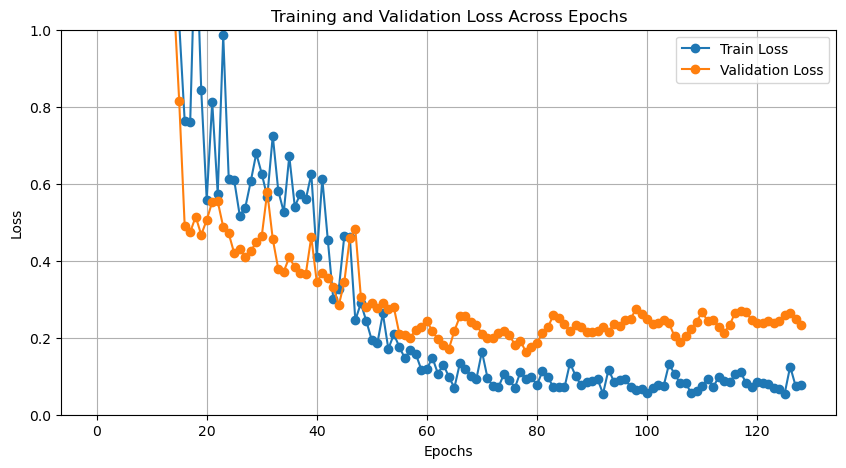

0.23360905051231384
Model 0 complete.
Training Model 1
epoch	train_loss	val_loss


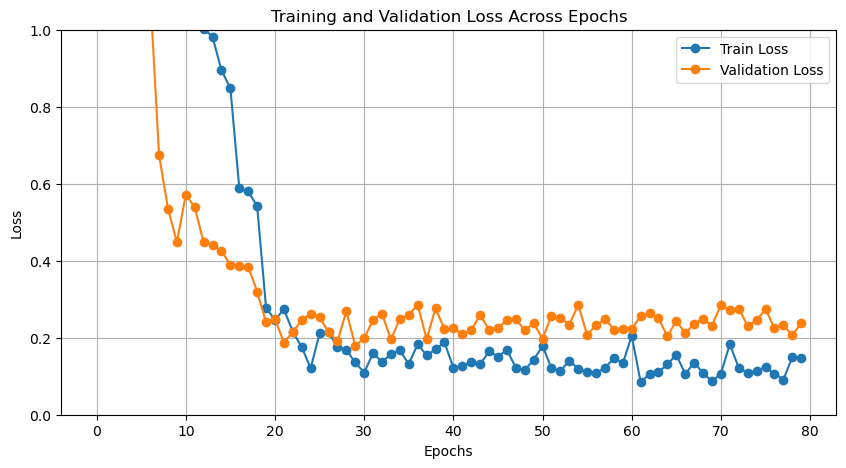

0.23751559829519642
Model 1 complete.
Training Model 2
epoch	train_loss	val_loss


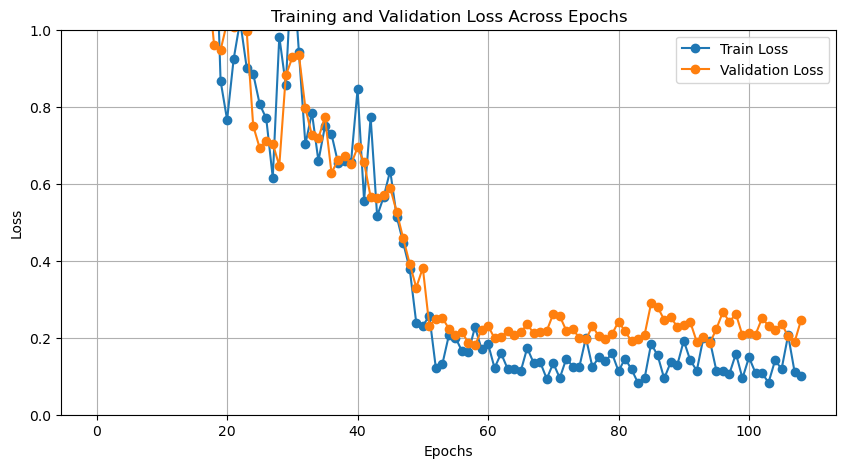

0.24707192615155252
Model 2 complete.
Training Model 3
epoch	train_loss	val_loss


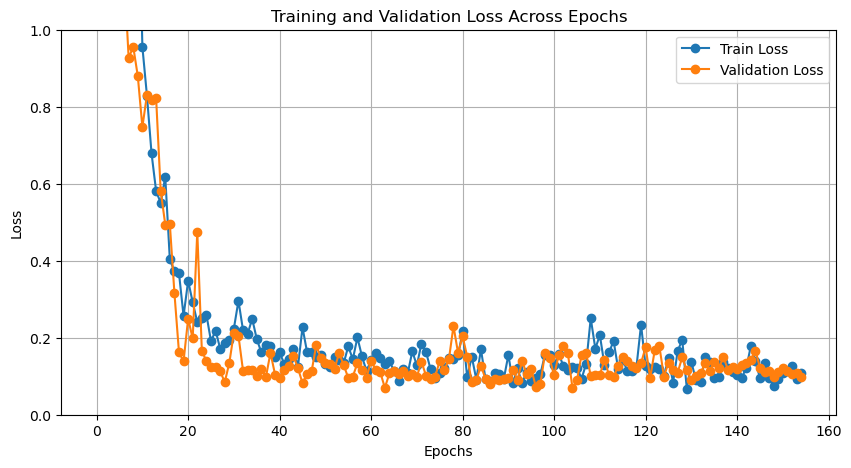

0.09698054723201259
Model 3 complete.
Training Model 4
epoch	train_loss	val_loss


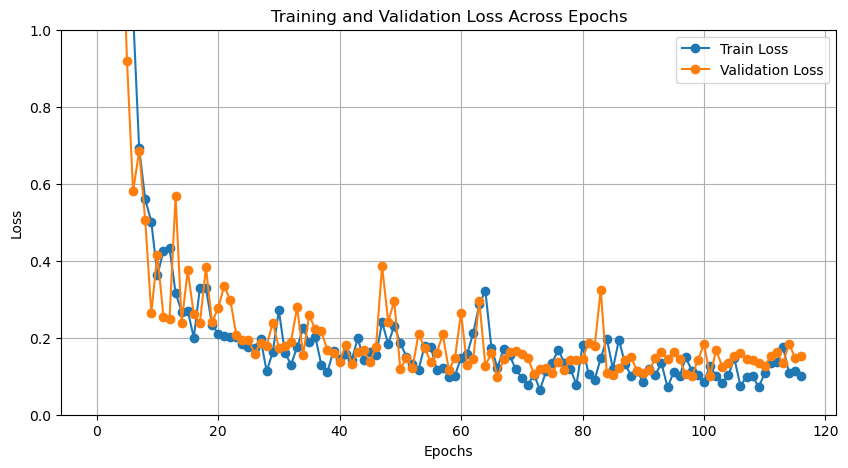

0.15193058922886848
Model 4 complete.


In [95]:
# Run Trainer

n_models = 5

for m in range(n_models):
    print(f"Training Model {m}")
    
    split = train_test_splits[m]
    x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test = get_wrapper(split, m)
    
    # Set random seed
    random_seed = m
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    
    # print(device)

    # Load pre-trained model
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)  # Model
    model.load_state_dict(torch.load('models/ontarget/final/model_{}.pt'.format(m)))  # Loads weights, biases from this pre-trained model

    # Create a Trainer instance for each model
    trainer = Trainer(model, x_train, g_train, y_train, x_validation, g_validation, y_validation)

    trainer.train_model()
    
    torch.save(model.state_dict(), f'models/endogenous/20240305_trial_2/model_{m}.pt')   # Model has now been updated after training, so store the model in a new folder

    print(f"Model {m} complete.")

### Now, run test sets through their respective models

In [96]:
def calculate_deepprime_score(df_input, num_model, pe_system='PE2', cell_type='HEK293T'):
    

    mean = pd.read_csv('../DeepPrime-main/models/DeepPrime/DeepPrime_base/mean.csv', header=None, index_col=0)
    std  = pd.read_csv('../DeepPrime-main/models/DeepPrime/DeepPrime_base/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std = std.squeeze('columns')

    test_features, test_target = select_cols(test) 

    g_test = seq_concat(test)
    x_test = (test_features - mean) / std

    g_test = torch.tensor(g_test, dtype=torch.float32, device=device)
    x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32, device=device)

    preds  = []

    # Model particular to the test dataset
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)
    model.load_state_dict(torch.load('models/endogenous/20240305_trial_2/model_{}.pt'.format(num_model)))  # Fine-tuned model

    
    model.eval()
    with torch.no_grad():
        g, x = g_test, x_test
        g = g.permute((0, 3, 1, 2))
        pred = model(g, x).detach().cpu().numpy()
    preds.append(pred)

    # Need this line!!
    preds = np.squeeze(np.array(preds))
    preds = np.exp(preds) - 1 # Really am not sure whether I need this line or not, so check with and without, probably
    
    return preds

In [97]:
all_test_df = []

for i in range(len(train_test_splits)):
    
    test_indices = train_test_splits[i][2] # This extracts out the test indices 
    print(test_indices)
    
    test = finetune_data.loc[test_indices] # Subset entire data just for the test indices used for this particular model
    test = test.reset_index(drop=True)
    
    
    test['DeepPrime_score'] = calculate_deepprime_score(test, num_model = i)
    
    
    all_test_df.append(test)
    test.to_csv('Test_' + str(i) + '.csv')
    
    

[73, 158, 173, 180, 71, 163, 197, 142, 39, 91, 112, 164, 61, 145, 28, 10, 198, 34, 89, 138, 94, 195, 90, 70, 125, 108, 2, 105, 14, 178, 124, 85, 52, 128, 53, 13, 166, 134, 7, 83]
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2095.27it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1605.26it/s]


Preprocessed the sequence
[103, 182, 132, 146, 107, 35, 30, 23, 175, 81, 0, 116, 144, 179, 74, 98, 5, 69, 36, 68, 102, 139, 9, 170, 135, 156, 131, 168, 185, 46, 151, 80, 58, 32, 78, 122, 19, 66, 188, 93]
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2260.90it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1630.82it/s]


Preprocessed the sequence
[6, 88, 65, 183, 55, 160, 119, 106, 42, 51, 50, 24, 11, 21, 20, 59, 115, 171, 149, 48, 186, 123, 104, 101, 159, 169, 113, 177, 187, 54, 189, 118, 31, 63, 141, 143, 4, 47, 136, 165]
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2208.52it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1718.99it/s]


Preprocessed the sequence
[82, 129, 100, 114, 161, 75, 25, 150, 181, 1, 64, 126, 22, 44, 79, 174, 152, 87, 172, 3, 16, 27, 38, 194, 26, 193, 92, 57, 96, 120, 76, 43, 97, 127, 12, 99, 184, 121, 148, 40]
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2328.16it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1634.57it/s]


Preprocessed the sequence
[72, 17, 60, 95, 130, 190, 67, 157, 45, 77, 191, 41, 167, 29, 33, 196, 86, 117, 192, 154, 176, 140, 56, 133, 153, 109, 18, 137, 155, 15, 147, 49, 162, 37, 84, 110, 62, 8, 111]
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 2272.83it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 1641.29it/s]


Preprocessed the sequence


In [98]:
# Concatenate all the test data frames

concatenated = pd.concat(all_test_df)
concatenated

,gene,ID,WT74_On,Edited74_On,PBSlen,RTlen,RT-PBSlen,Edit_pos,Edit_len,RHA_len,...,nGCcnt2,nGCcnt3,fGCcont1,fGCcont2,fGCcont3,MFE3,MFE4,DeepSpCas9_score,Measured_PE_efficiency,DeepPrime_score
0,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCACATTGTC...,13,28,41,5,1,23,...,14,22,61.538462,50.000000,53.658537,-9.4,-3.3,66.789276,25.172570,25.143074
1,HEK3,FIG2A_PE2_HEK3_10,TTGGGGCCCAGACTGAGCACGTGATGGCAGAGGAAAGGAAGCCCTG...,xxxxxxxxxxxACTGAGCACGAGATGGCAGAxxxxxxxxxxxxxxx...,10,10,20,1,1,9,...,5,11,60.000000,50.000000,55.000000,-0.2,-0.7,63.264858,5.620711,5.681259
2,HEK3,FIG2A_PE2_HEK3_10,TTGGGGCCCAGACTGAGCACGTGATGGCAGAGGAAAGGAAGCCCTG...,xxxxxxxxCAGACTGAGCACGAGATGGCAGAGGAAAGGxxxxxxxx...,13,17,30,1,1,16,...,9,17,61.538462,52.941176,56.666667,-0.6,-0.7,63.264858,1.814622,4.380079
3,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCGTTGTAAxxxxxxx...,15,18,33,1,1,17,...,7,12,33.333333,38.888889,36.363636,-1.6,0.0,52.229725,5.708600,4.441890
4,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCACATTGTC...,13,26,39,5,1,21,...,13,21,61.538462,50.000000,53.846154,-8.7,-3.3,66.789276,24.554598,25.816523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,EMX1,FIG2B_EMX1_10,GCCTGAGTCCGAGCAGAAGAAGAAGGGCTCCCATCACATCAACCGG...,xxxxxxxxCCGAGCAGAAGAACAAGGGCTCCCATCxxxxxxxxxxx...,13,14,27,1,1,13,...,9,16,53.846154,64.285714,59.259259,-4.4,0.0,69.540627,15.845670,15.154316
35,HEK4,FIG2A_PE2_HEK4_10,CGGTGGCACTGCGGCTGGAGGTGGGGGTTAAAGCGGAGACTCTGGT...,xxxxxxxACTGCGGCTGGAGGTTGGGGTTAAAGCxxxxxxxxxxxx...,14,13,27,2,1,11,...,6,16,71.428571,46.153846,59.259259,0.0,-3.5,54.310997,1.758639,2.897674
36,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCxxxxxxxx...,13,17,30,5,1,12,...,10,18,61.538462,58.823529,60.000000,-8.2,-3.3,66.789276,22.536342,16.009804
37,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACGGGAGxxxxxxxxx...,13,16,29,5,1,11,...,10,18,61.538462,62.500000,62.068966,-1.9,-1.6,65.144363,4.572178,4.464470


In [99]:
x = concatenated['Measured_PE_efficiency']
y = concatenated['DeepPrime_score']
                           
pearson_corr, pearson_p_value = pearsonr(x, y)
spearman_corr, spearman_p_value = spearmanr(x, y)
                        

print(pearson_corr, spearman_corr)

0.846714945548338 0.8597475482517556


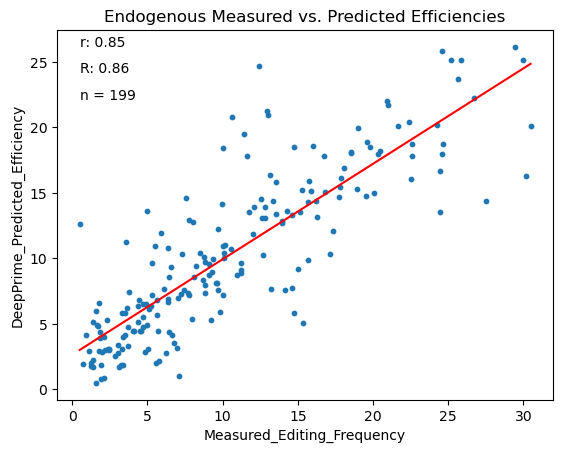

In [100]:
plt.scatter(x, y, s= 10)

# Add labels and title
plt.xlabel('Measured_Editing_Frequency')
plt.ylabel('DeepPrime_Predicted_Efficiency')
plt.title('Endogenous Measured vs. Predicted Efficiencies')
# plt.legend(title='Gene', loc = 'lower right')



plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', label='Regression Line (Pearson)')


plt.text(min(x), max(y), f"r: {pearson_corr:.2f}", fontsize=10)

# Annotate Spearman correlation coefficient
plt.text(min(x), max(y)-2, f"R: {spearman_corr:.2f}", fontsize=10)

plt.text(min(x), max(y)-4, "n = "+ str(len(concatenated)), fontsize=10)


# Show the plot
plt.show()

In [101]:
#Now, calculate correlations by gene and for the overall dataset

genes = list(concatenated['gene'].unique())
print(genes)

gene_correlations = pd.DataFrame()


for g in genes:
        
    
    subset = concatenated.loc[concatenated['gene'] == g]
    # print(g, len(subset))

                           
    x_sub = subset['Measured_PE_efficiency']
    y_sub = subset['DeepPrime_score']
    
    print(g, len(subset))
    

                           
    pearson_corr, pearson_p_value = pearsonr(x_sub, y_sub)
    spearman_corr, spearman_p_value = spearmanr(x_sub, y_sub)

                           
    if g not in gene_correlations:

        gene_correlations[g] = [0,0]
        gene_correlations[g] = pearson_corr
        gene_correlations[g][1] = spearman_corr
        
    else:
        gene_correlations[g][0] = pearson_corr
        gene_correlations[g][1] = spearman_corr
        

gene_correlations.index = ['Pearson','Spearman']
gene_correlations

['VEGFA', 'HEK3', 'RNF2', 'FANCF', 'HEK4', 'EMX1', 'DNMT1', 'RUNX1']
VEGFA 24
HEK3 27
RNF2 23
FANCF 28
HEK4 24
EMX1 25
DNMT1 24
RUNX1 24


,VEGFA,HEK3,RNF2,FANCF,HEK4,EMX1,DNMT1,RUNX1
Pearson,0.790114,0.759317,0.801958,0.401636,0.750716,0.571264,0.717037,0.844381
Spearman,0.850435,0.829060,0.769763,0.412207,0.520870,0.608462,0.789565,0.855652


<Figure size 640x480 with 0 Axes>

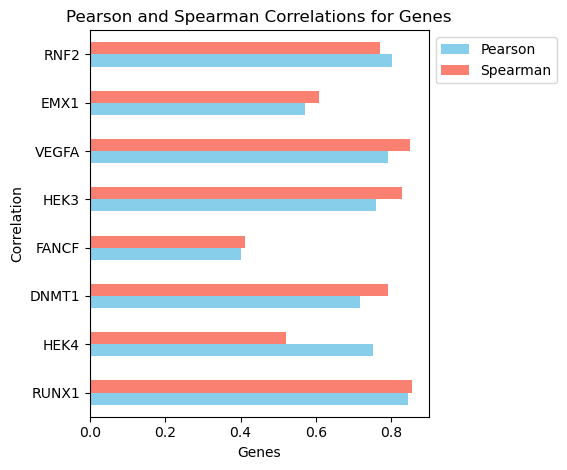

In [102]:
# Plot the bar chart

gene_correlations_t = gene_correlations.transpose()   #Transposed dataframe
# genes_order = genes[::-1]
genes_order = ['RNF2','EMX1', 'VEGFA','HEK3', 'FANCF', 'DNMT1', 'HEK4', 'RUNX1'][::-1]
gene_correlations_t = gene_correlations_t.loc[genes_order]




# Show the plot
plt.tight_layout()
plt.show()
ax = gene_correlations_t.plot(kind='barh', rot=0, color=['skyblue', 'salmon'])

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Correlation')
ax.set_title('Pearson and Spearman Correlations for Genes')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# Show the plot
plt.tight_layout()
plt.show()

0.846714945548338 0.8597475482517556


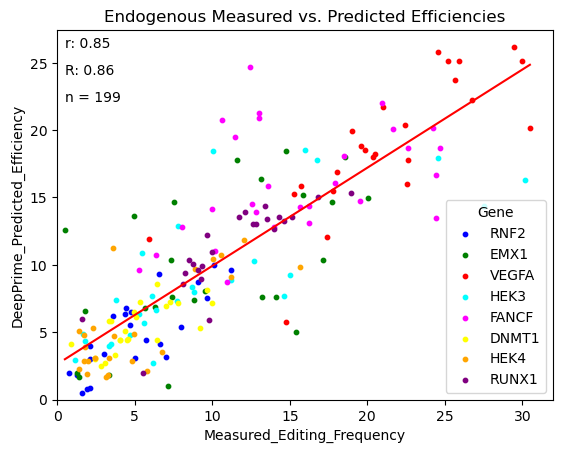

In [103]:
color_mapping = {
    'RNF2': 'blue',
    'EMX1': 'green',
    'VEGFA': 'red',
    'HEK3': 'cyan',
    'FANCF': 'magenta',
    'DNMT1': 'yellow',
    'HEK4': 'orange',
    'RUNX1': 'purple'
}


# plt.scatter(x, y, s= 0.5, alpha=0.5)

x = concatenated['Measured_PE_efficiency']
y = concatenated['DeepPrime_score']
                           
pearson_corr, pearson_p_value = pearsonr(x, y)
spearman_corr, spearman_p_value = spearmanr(x, y)

for gene, color in color_mapping.items():
    plt.scatter(x[concatenated['gene'] == gene], y[concatenated['gene'] == gene], 
                s=10, c=color, label=gene)

print(pearson_corr, spearman_corr)

# Add labels and title
plt.xlabel('Measured_Editing_Frequency')
plt.ylabel('DeepPrime_Predicted_Efficiency')
plt.title('Endogenous Measured vs. Predicted Efficiencies')
plt.legend(title='Gene', loc = 'lower right')

plt.xlim(left=0)
plt.ylim(bottom = 0)


plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', label='Regression Line (Pearson)')


plt.text(min(x), max(y), f"r: {pearson_corr:.2f}", fontsize=10)

# Annotate Spearman correlation coefficient
plt.text(min(x), max(y)-2, f"R: {spearman_corr:.2f}", fontsize=10)

plt.text(min(x), max(y)-4, "n = "+ str(len(concatenated)), fontsize=10)


# Show the plot
plt.show()

In [104]:
gene_correlations_base = pd.read_csv("GeneCorrelations_Base.csv", index_col=None)
# gene_correlations_base = gene_correlations_base.drop(columns=['Unnamed: 0'])


row_names = ['Pearson', 'Spearman']  # Assuming these are the row names


# Assign row names to the DataFrame
gene_correlations_base.index = row_names
gene_correlations_base

,DNMT1,EMX1,HEK3,FANCF,VEGFA,RNF2,HEK4,RUNX1
Pearson,0.799051,0.208157,0.721827,0.31728,0.659244,0.686267,0.684819,0.827996
Spearman,0.792174,0.412002,0.680812,0.35547,0.578261,0.717252,0.616355,0.853913


In [105]:
gene_correlations_FT = gene_correlations
gene_correlations_FT = gene_correlations_FT.reindex(columns=gene_correlations_base.columns)
gene_correlations_FT

,DNMT1,EMX1,HEK3,FANCF,VEGFA,RNF2,HEK4,RUNX1
Pearson,0.717037,0.571264,0.759317,0.401636,0.790114,0.801958,0.750716,0.844381
Spearman,0.789565,0.608462,0.829060,0.412207,0.850435,0.769763,0.520870,0.855652


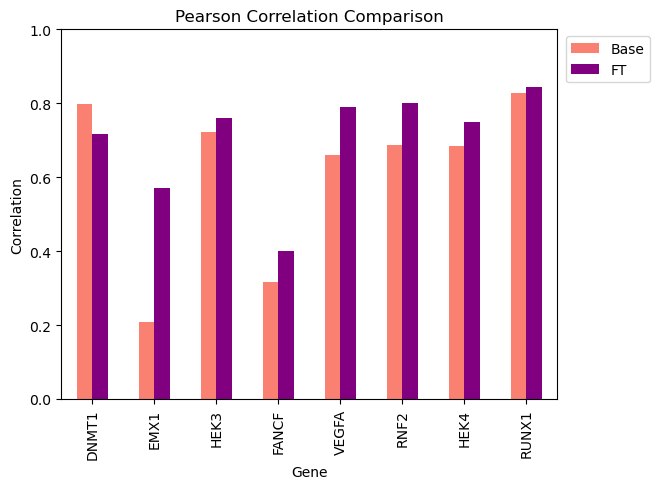

In [111]:
# Extracting the pearson correlation values for each gene
genes = gene_correlations_base.columns.tolist()  # Assuming columns represent genes
pearson_corrs_df1 = gene_correlations_base.iloc[0].tolist()  # Assuming row 0 is for Pearson correlation
pearson_corrs_df2 = gene_correlations_FT.iloc[0].tolist()  # Assuming row 0 is for Pearson correlation

color_base = 'salmon'   # Color for bars representing DataFrame 1 (base)
color_FT = 'purple'   # Color for bars representing DataFrame 2 (FT)

# Creating a DataFrame to hold both sets of correlation values
corrs_df = pd.DataFrame({
    'Gene': genes,
    'Base': pearson_corrs_df1,
    'FT': pearson_corrs_df2
})

# Plotting the correlations
ax = corrs_df.plot(x='Gene', kind='bar', color=[color_base, color_FT])
# corrs_df.plot(x='Gene', kind='bar')
plt.xlabel('Gene')
plt.ylabel('Correlation')
plt.ylim(0.0, 1.0)
plt.title('Pearson Correlation Comparison')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

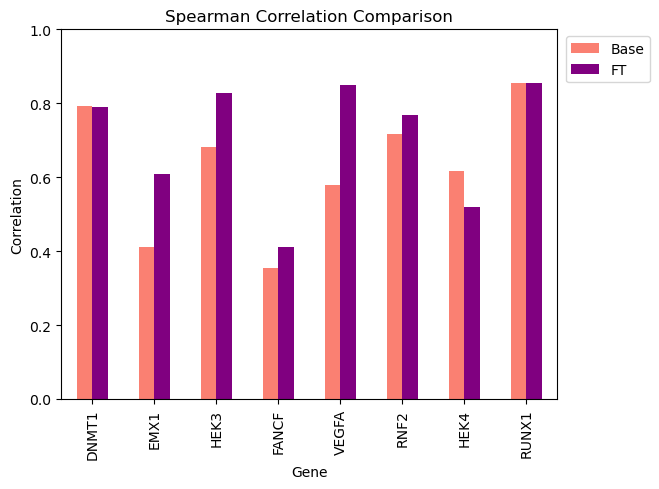

In [110]:
# Extracting the spearman correlation values for each gene
genes = gene_correlations_base.columns.tolist()  # Assuming columns represent genes
spearman_corrs_df1 = gene_correlations_base.iloc[1].tolist()  # Assuming row 0 is for Pearson correlation
spearman_corrs_df2 = gene_correlations_FT.iloc[1].tolist()  # Assuming row 0 is for Pearson correlation

color_base = 'salmon'   # Color for bars representing DataFrame 1 (base)
color_FT = 'purple'   # Color for bars representing DataFrame 2 (FT)

# Creating a DataFrame to hold both sets of correlation values
corrs_df = pd.DataFrame({
    'Gene': genes,
    'Base': spearman_corrs_df1,
    'FT': spearman_corrs_df2
})

# Plotting the correlations
ax = corrs_df.plot(x='Gene', kind='bar', color=[color_base, color_FT])
# corrs_df.plot(x='Gene', kind='bar')
plt.xlabel('Gene')
plt.ylabel('Correlation')
plt.ylim(0.0, 1.0)
plt.title('Spearman Correlation Comparison')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()